In [1]:
%load_ext autoreload
%autoreload 2
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from typing import List, Tuple, Dict, Union, Any, Optional
from tqdm import tqdm
import json
try:
    os.chdir(os.path.join(os.getcwd(), '../../Language-Technology-Project'))
    print(os.getcwd())
except:
    print("ALready in current dir")

c:\Users\mo\Documents\Organisations\RUG\Language-Technology-Project


In [2]:
df = pd.read_csv("datasets/training_merged.csv")
df = df.drop(df.columns[0], axis=1)
df = df.dropna()

df_labels = df.loc[:, df.columns != "Merged"]
df_labels = df_labels.astype(int)
df_labels = df_labels.values.tolist()
df_labels = torch.tensor(df_labels)
df_labels = df_labels.to(torch.float32)

df_inputs = df["Merged"].to_list()
df.head(3)

,Merged,Self-direction: thought,Self-direction: action,Stimulation,Hedonism,Achievement,Power: dominance,Power: resources,Face,Security: personal,...,Tradition,Conformity: rules,Conformity: interpersonal,Humility,Benevolence: caring,Benevolence: dependability,Universalism: concern,Universalism: nature,Universalism: tolerance,Universalism: objectivity
0,we should ban human cloning as it will only ca...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,fast food should be banned because it is reall...,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,sometimes economic sanctions are the only thin...,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
from sentence_transformers import SentenceTransformer

class HumanValuesDataset(torch.utils.data.Dataset):
    def __init__(self, inputs, labels, device):
        self.inputs = inputs
        self.labels = labels
        self.model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2').to(device)
        self.__preprocess()
        
    def __preprocess(self):
        self.inputs = self.model.encode(self.inputs, show_progress_bar=True)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, index):
        return self.inputs[index], self.labels[index]

In [4]:
data_loader = torch.utils.data.DataLoader(
    HumanValuesDataset(df_inputs, df_labels, torch.device('cuda:0')),
    batch_size=1024,
    shuffle=True,
    num_workers=0,
)

Batches:   0%|          | 0/169 [00:00<?, ?it/s]

In [5]:
def load_data(path):
    df = pd.read_csv(path)
    df = df.drop(df.columns[0], axis=1)
    df = df.dropna()

    df_labels = df.loc[:, df.columns != "Merged"]
    df_labels = df_labels.astype(int)
    df_labels = df_labels.values.tolist()
    df_labels = torch.tensor(df_labels)
    df_labels = df_labels.to(torch.float32)

    df_inputs = df["Merged"].to_list()

    return df_inputs, df_labels

def create_dataloader(path, device, batch_size=1024, shuffle=True, num_workers=0, *args, **kwargs):
    df_inputs, df_labels = load_data(path)

    return torch.utils.data.DataLoader(
        HumanValuesDataset(df_inputs, df_labels, device),
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=num_workers,
        *args,
        **kwargs
    )

In [6]:
class HVClassifier(torch.nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')
        for param in self.model.parameters():
            param.requires_grad = False
        
        self.fc1 = torch.nn.Linear(768, 512)
        self.bn1 = torch.nn.BatchNorm1d(512)
        self.dropout1 = torch.nn.Dropout(0.2)
        self.fc2 = torch.nn.Linear(512, 128)
        self.bn2 = torch.nn.BatchNorm1d(128)
        self.dropout2 = torch.nn.Dropout(0.2)
        self.fc3 = torch.nn.Linear(128, 64)
        self.bn3 = torch.nn.BatchNorm1d(64)
        self.dropout3 = torch.nn.Dropout(0.2)
        self.fc4 = torch.nn.Linear(64, 32)
        self.bn4 = torch.nn.BatchNorm1d(32)
        self.dropout4 = torch.nn.Dropout(0.2)
        self.fc5 = torch.nn.Linear(32, 20)
        self.bn5 = torch.nn.BatchNorm1d(20)
        self.dropout5 = torch.nn.Dropout(0.2)
        self.fc6 = torch.nn.Linear(20, 20)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x is already encoded, use relu activation
        x = torch.relu(self.fc1(x))
        x = self.bn1(x)
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.bn2(x)
        x = self.dropout2(x)
        x = torch.relu(self.fc3(x))
        x = self.bn3(x)
        x = self.dropout3(x)
        x = torch.relu(self.fc4(x))
        x = self.bn4(x)
        x = self.dropout4(x)
        x = torch.relu(self.fc5(x))
        x = self.bn5(x)
        x = self.dropout5(x)
        x = self.fc6(x)
        x = self.sigmoid(x)
        return x
    
    def predict(self, x: List[str], return_type="pt") -> np.ndarray:
        x = self.model.encode(x, convert_to_tensor=True, device=next(self.parameters()).device)
        x = self.forward(x)
        x = x.cpu().detach()
        if return_type == "pt":
            return x
        elif return_type == "np":
            return x.numpy()

In [7]:
device = torch.device('cuda:0')
model = HVClassifier().to(device)

In [8]:
train_loader = create_dataloader("datasets/training_merged.csv", device)
val_loader = create_dataloader("datasets/test_merged.csv", device)

Batches:   0%|          | 0/169 [00:00<?, ?it/s]

Batches:   0%|          | 0/50 [00:00<?, ?it/s]

In [9]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score

  0%|          | 0/1200 [00:00<?, ?it/s]

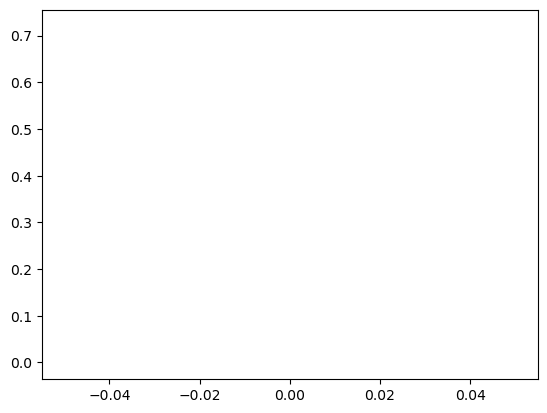

  0%|          | 3/1200 [00:00<01:42, 11.66it/s]

Epoch 1/1200 - loss: 0.7195785045623779, f1: 0.0


  1%|          | 9/1200 [00:00<01:19, 14.90it/s]

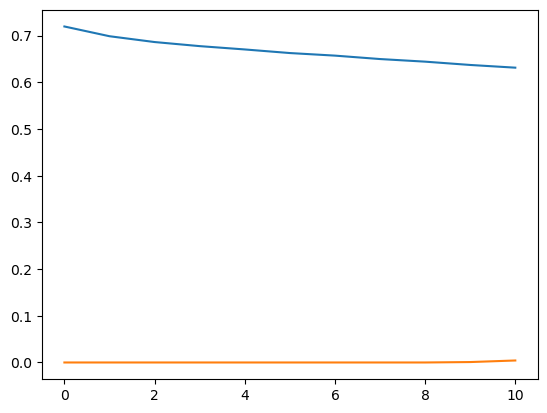

Epoch 11/1200 - loss: 0.6313635806242625, f1: 0.0042607459786691265


  2%|▏         | 20/1200 [00:06<10:44,  1.83it/s]

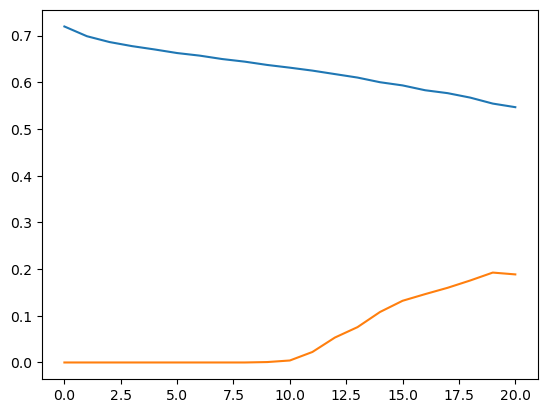

  2%|▏         | 21/1200 [00:07<08:28,  2.32it/s]

Epoch 21/1200 - loss: 0.5467629233996073, f1: 0.1886178536470638


  2%|▎         | 30/1200 [00:09<04:38,  4.20it/s]

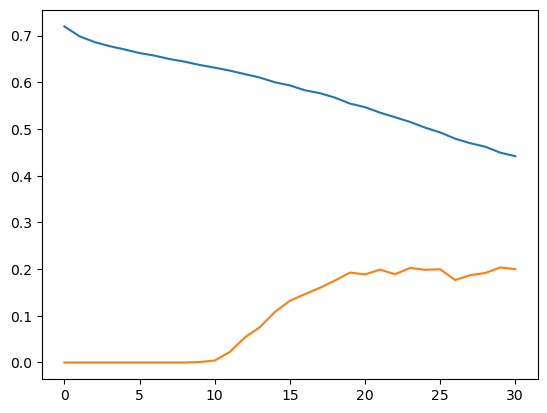

  3%|▎         | 33/1200 [00:09<03:08,  6.18it/s]

Epoch 31/1200 - loss: 0.44175971547762555, f1: 0.19981167049952075


  3%|▎         | 39/1200 [00:09<01:51, 10.38it/s]

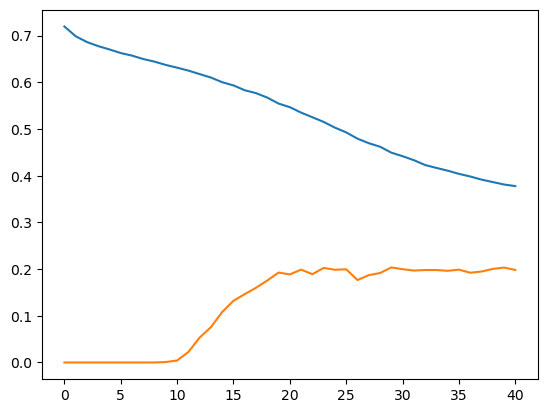

  3%|▎         | 41/1200 [00:10<01:54, 10.10it/s]

Epoch 41/1200 - loss: 0.37774093945821124, f1: 0.19819940885815018


  4%|▍         | 50/1200 [00:12<05:46,  3.32it/s]

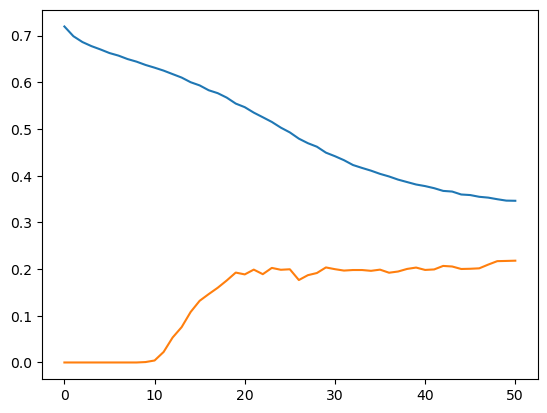

Epoch 51/1200 - loss: 0.34628892938296, f1: 0.21799519587523625


  5%|▍         | 59/1200 [00:16<08:33,  2.22it/s]

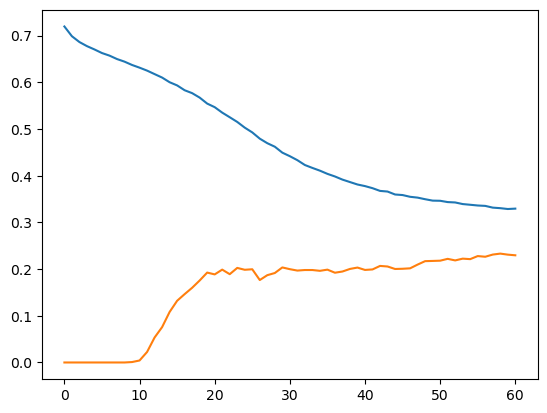

  5%|▌         | 63/1200 [00:17<04:03,  4.67it/s]

Epoch 61/1200 - loss: 0.329486941297849, f1: 0.22955055186245327


  6%|▌         | 70/1200 [00:18<03:30,  5.36it/s]

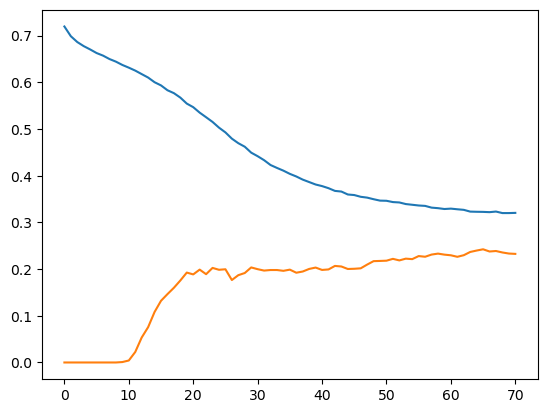

  6%|▌         | 71/1200 [00:19<03:20,  5.62it/s]

Epoch 71/1200 - loss: 0.32037385801474255, f1: 0.23257345885528025


  7%|▋         | 80/1200 [00:22<07:50,  2.38it/s]

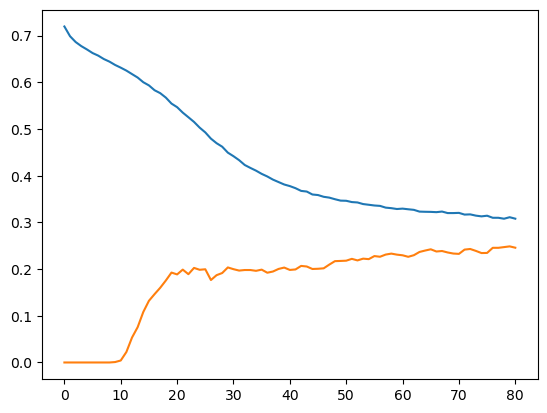

  7%|▋         | 83/1200 [00:22<04:23,  4.23it/s]

Epoch 81/1200 - loss: 0.30795683960119885, f1: 0.2457888614106125


  8%|▊         | 90/1200 [00:24<06:05,  3.03it/s]

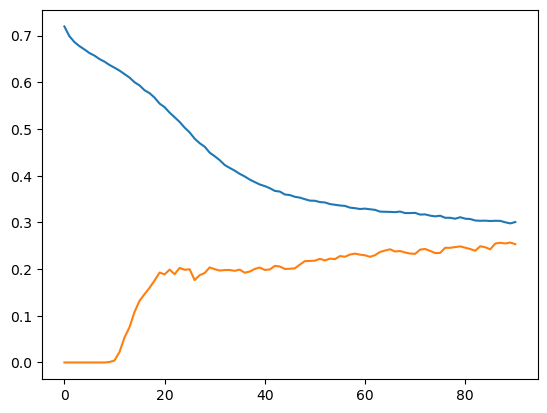

  8%|▊         | 91/1200 [00:25<05:49,  3.17it/s]

Epoch 91/1200 - loss: 0.30074072380860645, f1: 0.25330370058101437


  8%|▊         | 99/1200 [00:27<04:55,  3.73it/s]

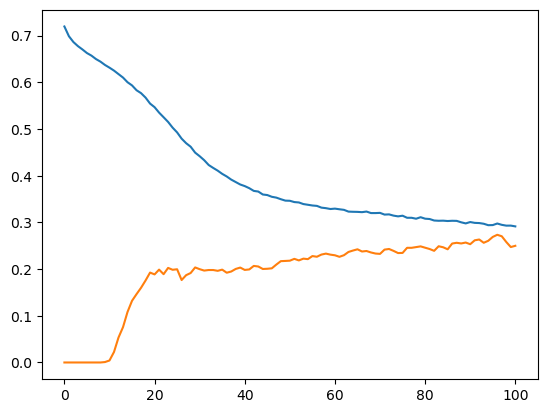

  8%|▊         | 102/1200 [00:28<03:22,  5.42it/s]

Epoch 101/1200 - loss: 0.29145004351933795, f1: 0.24985985203549063


  9%|▉         | 110/1200 [00:28<01:33, 11.62it/s]

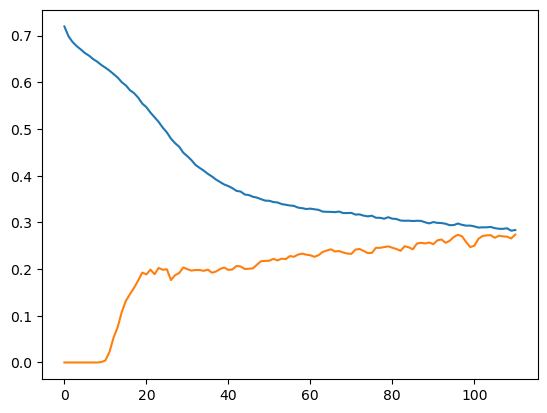

Epoch 111/1200 - loss: 0.28366346657276154, f1: 0.273937487042646


 10%|█         | 120/1200 [00:31<04:40,  3.85it/s]

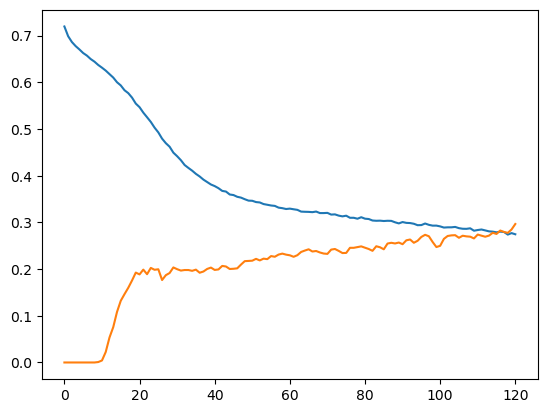

Epoch 121/1200 - loss: 0.27457238733768463, f1: 0.29655576378999216


 11%|█         | 130/1200 [00:32<02:05,  8.53it/s]

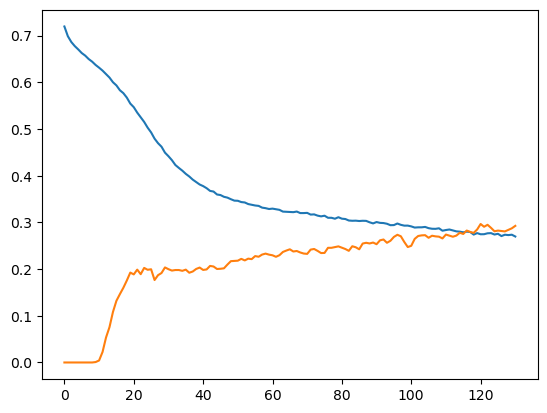

 11%|█         | 132/1200 [00:32<02:00,  8.85it/s]

Epoch 131/1200 - loss: 0.26978015899658203, f1: 0.292587609767764


 12%|█▏        | 140/1200 [00:33<01:23, 12.76it/s]

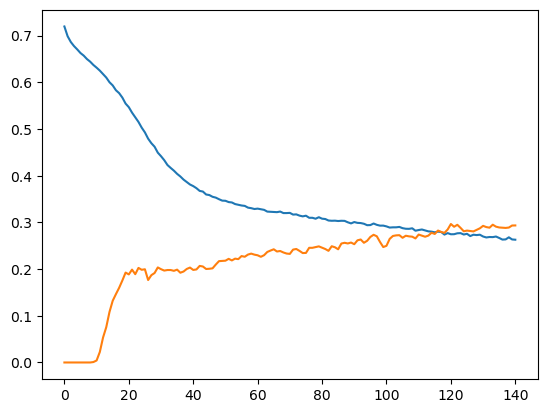

Epoch 141/1200 - loss: 0.2629351069529851, f1: 0.29347560973011366


 12%|█▎        | 150/1200 [00:35<02:49,  6.21it/s]

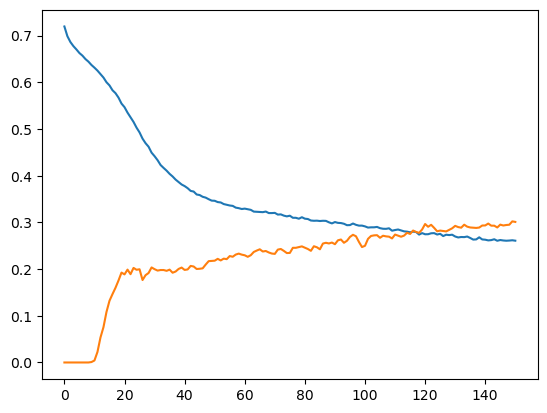

 13%|█▎        | 152/1200 [00:35<02:31,  6.92it/s]

Epoch 151/1200 - loss: 0.26082171499729156, f1: 0.3010342781704999


 13%|█▎        | 160/1200 [00:37<03:00,  5.76it/s]

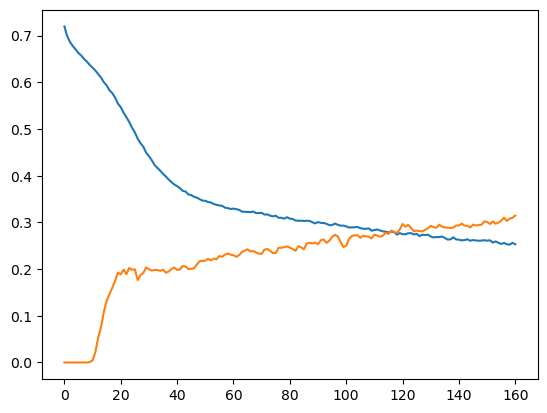

Epoch 161/1200 - loss: 0.25315583993991214, f1: 0.3146628045182359


 14%|█▍        | 169/1200 [00:38<01:51,  9.21it/s]

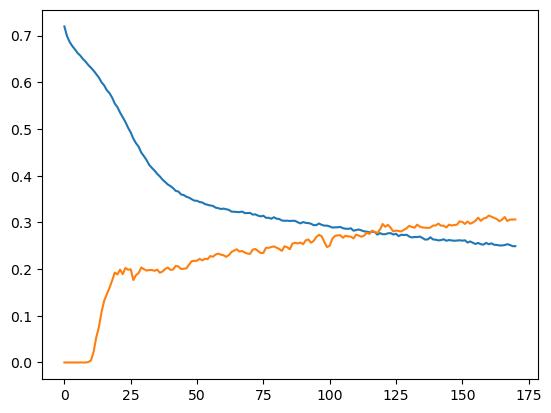

 14%|█▍        | 173/1200 [00:38<01:36, 10.68it/s]

Epoch 171/1200 - loss: 0.24912544091542563, f1: 0.3063685761516071


 15%|█▍        | 179/1200 [00:39<01:16, 13.31it/s]

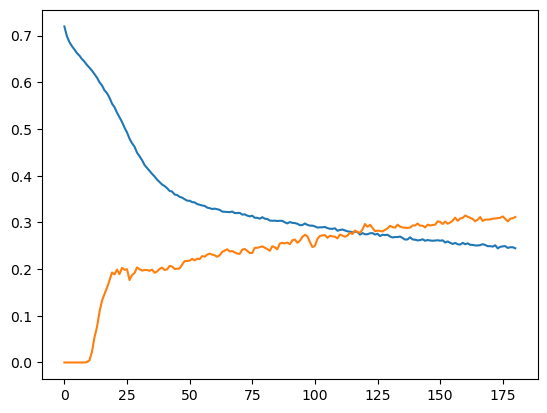

 15%|█▌        | 181/1200 [00:39<01:29, 11.36it/s]

Epoch 181/1200 - loss: 0.24455989400545755, f1: 0.31152656793321665


 16%|█▌        | 190/1200 [00:42<05:11,  3.24it/s]

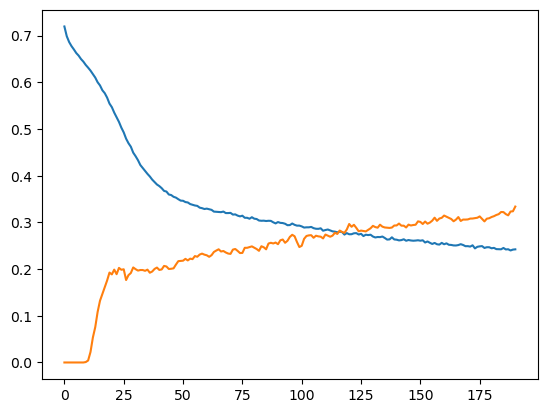

Epoch 191/1200 - loss: 0.2422926053404808, f1: 0.33389196054324555


 17%|█▋        | 199/1200 [00:43<01:58,  8.48it/s]

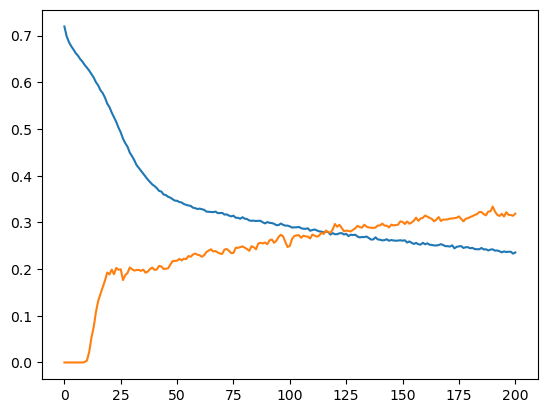

 17%|█▋        | 203/1200 [00:44<01:35, 10.41it/s]

Epoch 201/1200 - loss: 0.23561272025108337, f1: 0.31868105606128916


 17%|█▋        | 209/1200 [00:44<01:21, 12.11it/s]

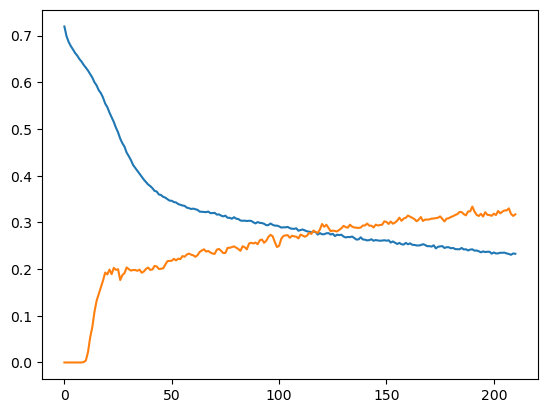

 18%|█▊        | 213/1200 [00:44<01:18, 12.59it/s]

Epoch 211/1200 - loss: 0.23277943581342697, f1: 0.31714355299493063


 18%|█▊        | 219/1200 [00:45<01:09, 14.18it/s]

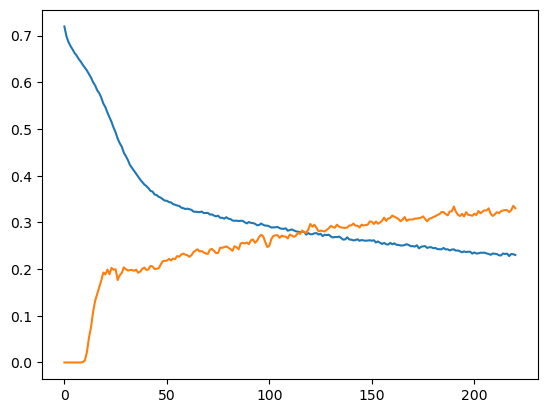

 19%|█▊        | 223/1200 [00:46<02:09,  7.55it/s]

Epoch 221/1200 - loss: 0.2302238792181015, f1: 0.33038037293899014


 19%|█▉        | 229/1200 [00:46<01:40,  9.64it/s]

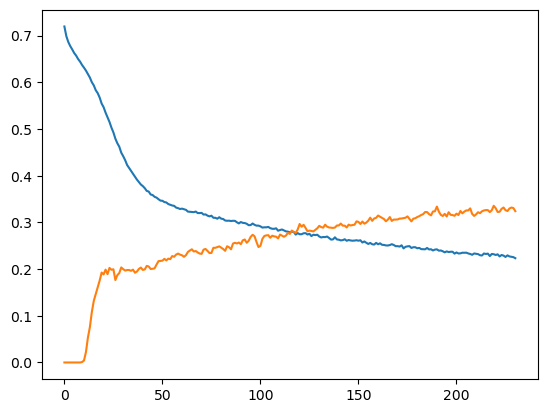

 19%|█▉        | 233/1200 [00:46<01:28, 10.99it/s]

Epoch 231/1200 - loss: 0.2233537957072258, f1: 0.324119859512593


 20%|█▉        | 239/1200 [00:47<01:14, 12.91it/s]

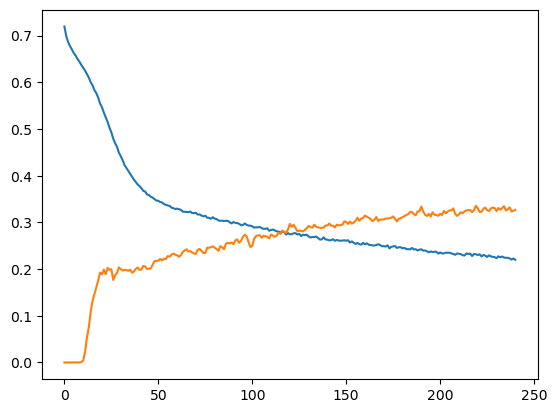

 20%|██        | 243/1200 [00:47<01:14, 12.85it/s]

Epoch 241/1200 - loss: 0.21984740843375525, f1: 0.3269073449795964


 21%|██        | 249/1200 [00:48<01:12, 13.11it/s]

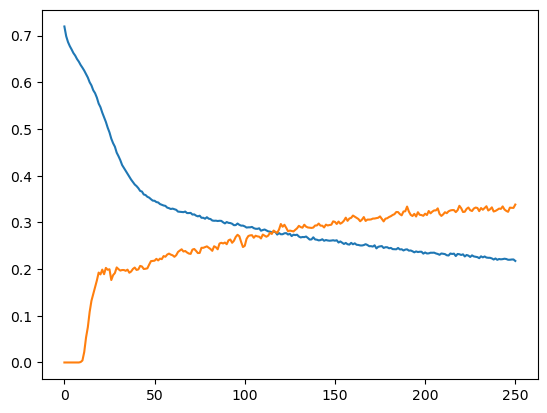

Epoch 251/1200 - loss: 0.21746173004309335, f1: 0.3381992232566897


 22%|██▏       | 259/1200 [00:49<01:21, 11.61it/s]

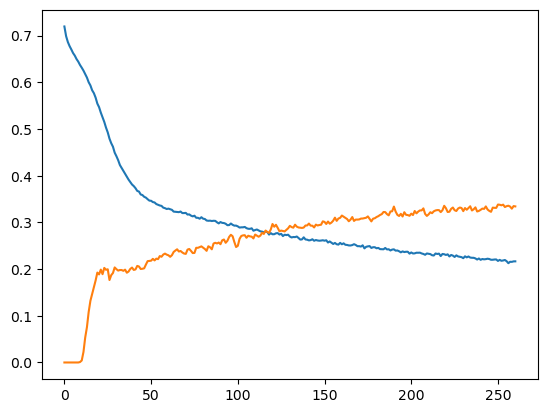

 22%|██▏       | 261/1200 [00:49<01:27, 10.72it/s]

Epoch 261/1200 - loss: 0.21659771104653677, f1: 0.3342523763102918


 22%|██▎       | 270/1200 [00:51<02:08,  7.25it/s]

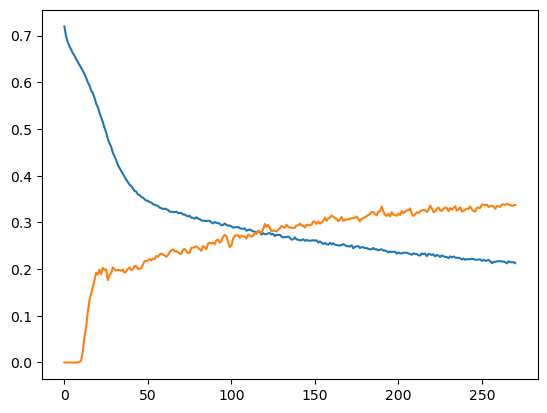

 23%|██▎       | 274/1200 [00:51<01:39,  9.34it/s]

Epoch 271/1200 - loss: 0.21261005848646164, f1: 0.33725884187445054


 23%|██▎       | 280/1200 [00:51<01:19, 11.62it/s]

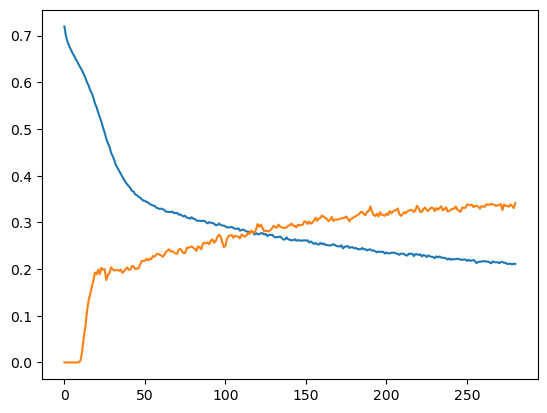

Epoch 281/1200 - loss: 0.2108063598473867, f1: 0.34145727161078665


 24%|██▍       | 290/1200 [00:53<01:28, 10.23it/s]

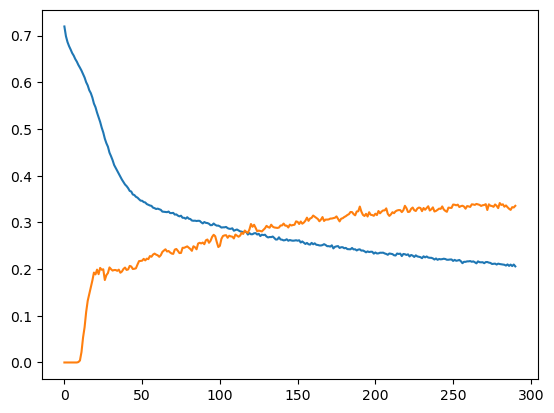

 24%|██▍       | 294/1200 [00:53<01:19, 11.38it/s]

Epoch 291/1200 - loss: 0.20582476258277893, f1: 0.3355059929435446


 25%|██▌       | 300/1200 [00:54<01:15, 11.91it/s]

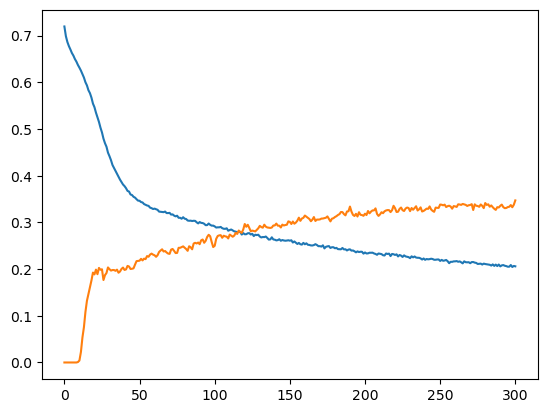

Epoch 301/1200 - loss: 0.20594765742619833, f1: 0.3470895738015859


 26%|██▌       | 310/1200 [00:55<01:20, 11.00it/s]

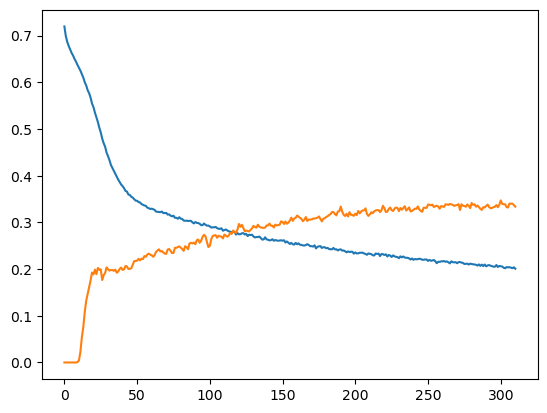

 26%|██▌       | 312/1200 [00:55<01:23, 10.63it/s]

Epoch 311/1200 - loss: 0.2008159632484118, f1: 0.33373927014273996


 27%|██▋       | 320/1200 [00:56<01:05, 13.34it/s]

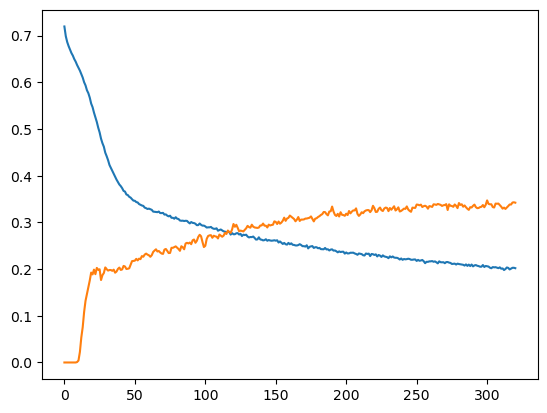

 27%|██▋       | 322/1200 [00:56<01:14, 11.75it/s]

Epoch 321/1200 - loss: 0.20194263259569803, f1: 0.34224051140726663


 28%|██▊       | 330/1200 [00:57<01:49,  7.93it/s]

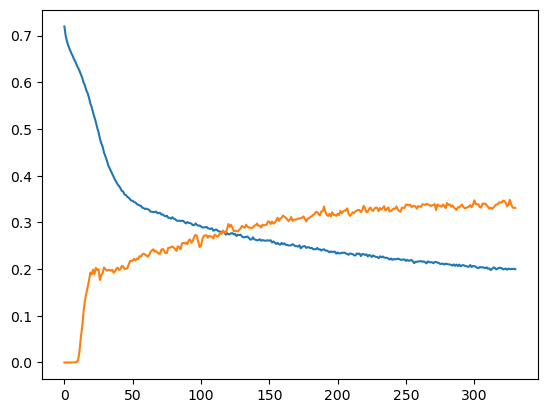

 28%|██▊       | 332/1200 [00:57<01:45,  8.22it/s]

Epoch 331/1200 - loss: 0.19988897691170374, f1: 0.33122085069142926


 28%|██▊       | 340/1200 [00:59<02:36,  5.51it/s]

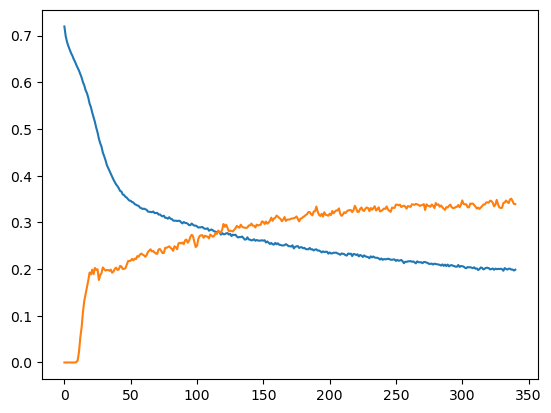

 28%|██▊       | 342/1200 [00:59<02:22,  6.03it/s]

Epoch 341/1200 - loss: 0.1986843173702558, f1: 0.3390580110071927


 29%|██▉       | 350/1200 [00:59<01:18, 10.80it/s]

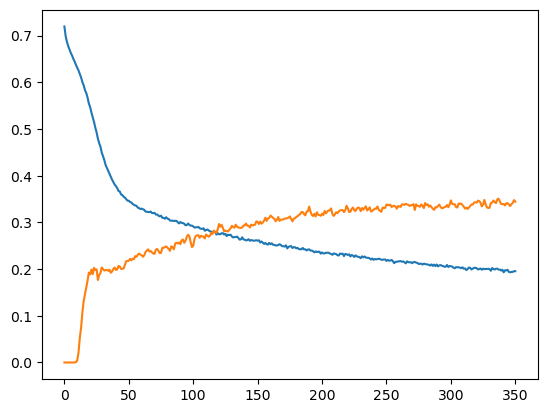

 30%|██▉       | 354/1200 [01:00<01:12, 11.67it/s]

Epoch 351/1200 - loss: 0.19550275802612305, f1: 0.3445060125481326


 30%|███       | 360/1200 [01:00<01:03, 13.13it/s]

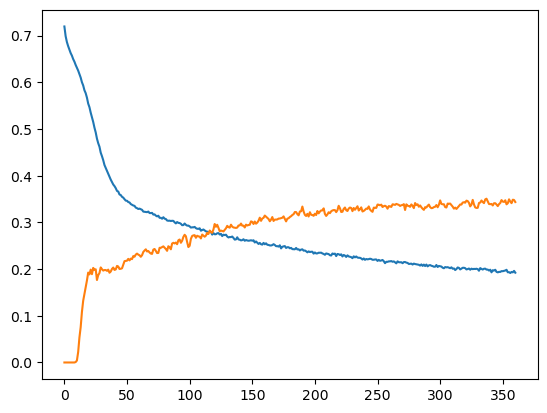

 30%|███       | 364/1200 [01:01<01:06, 12.62it/s]

Epoch 361/1200 - loss: 0.19225676854451498, f1: 0.34360984972914776


 31%|███       | 370/1200 [01:01<01:10, 11.83it/s]

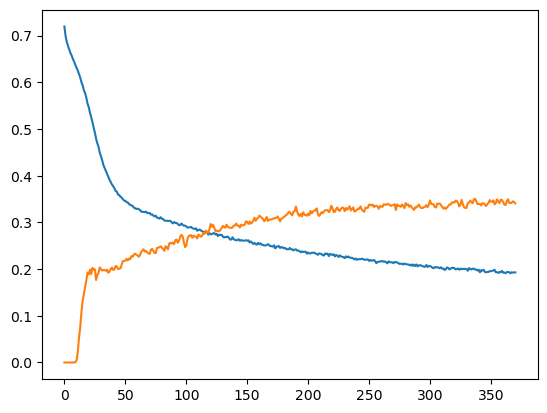

 31%|███       | 372/1200 [01:01<01:12, 11.37it/s]

Epoch 371/1200 - loss: 0.1929242635766665, f1: 0.3405311461699294


 32%|███▏      | 380/1200 [01:02<01:06, 12.37it/s]

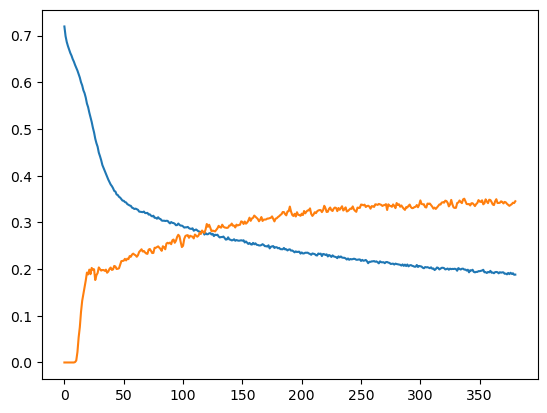

 32%|███▏      | 382/1200 [01:02<01:10, 11.65it/s]

Epoch 381/1200 - loss: 0.18815654764572778, f1: 0.34528125044391156


 32%|███▎      | 390/1200 [01:03<01:10, 11.57it/s]

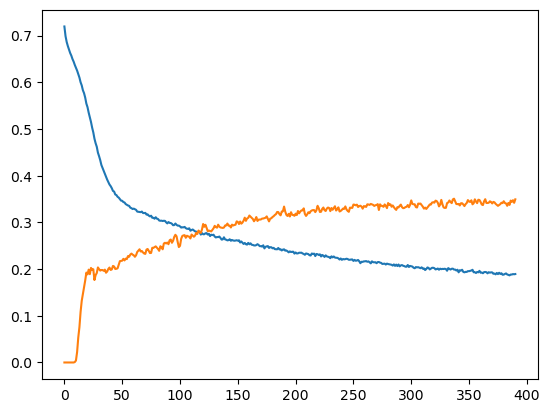

 33%|███▎      | 392/1200 [01:03<01:17, 10.40it/s]

Epoch 391/1200 - loss: 0.18937666962544122, f1: 0.3493693581363848


 33%|███▎      | 399/1200 [01:04<01:23,  9.57it/s]

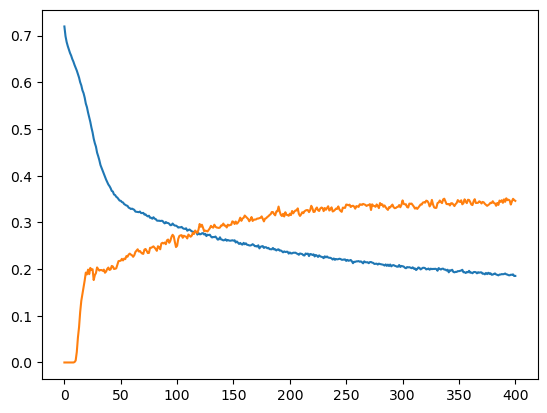

 33%|███▎      | 401/1200 [01:04<01:37,  8.20it/s]

Epoch 401/1200 - loss: 0.18534578879674277, f1: 0.3460680588448741


 34%|███▍      | 409/1200 [01:06<02:28,  5.33it/s]

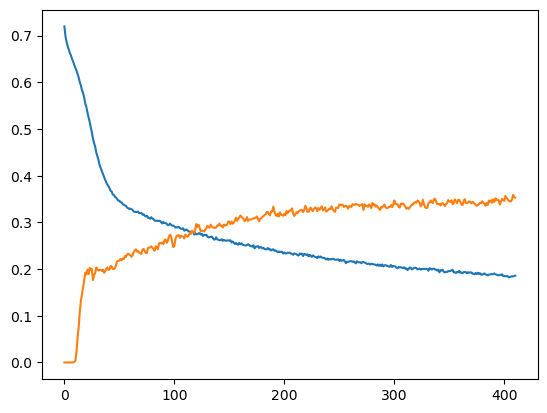

 34%|███▍      | 413/1200 [01:06<01:43,  7.61it/s]

Epoch 411/1200 - loss: 0.18593518187602362, f1: 0.3530702878299311


 35%|███▍      | 419/1200 [01:07<01:13, 10.65it/s]

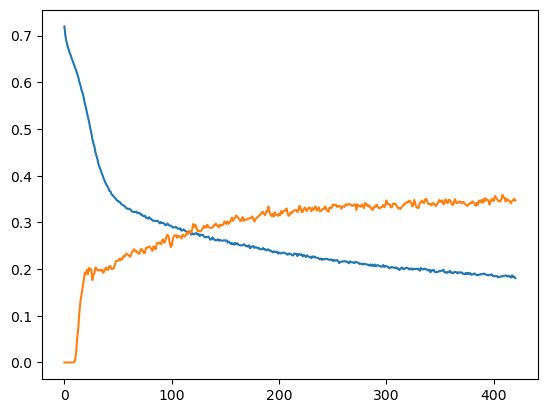

 35%|███▌      | 423/1200 [01:07<01:06, 11.67it/s]

Epoch 421/1200 - loss: 0.18066283812125525, f1: 0.34680401470067707


 36%|███▌      | 429/1200 [01:07<00:55, 13.87it/s]

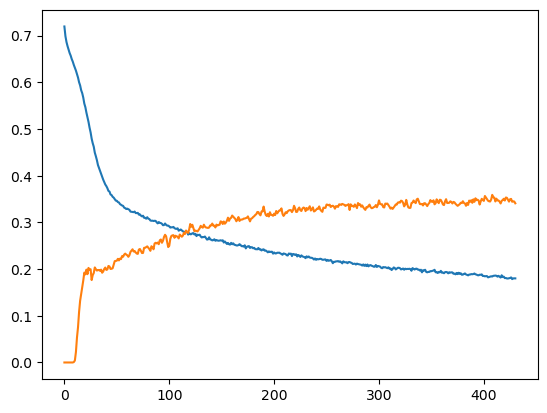

 36%|███▌      | 431/1200 [01:08<01:00, 12.69it/s]

Epoch 431/1200 - loss: 0.18011747052272162, f1: 0.340866911987615


 37%|███▋      | 439/1200 [01:08<00:58, 13.01it/s]

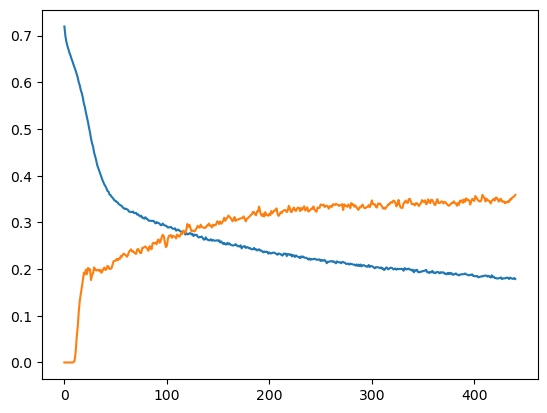

Epoch 441/1200 - loss: 0.17887732138236365, f1: 0.35906042167204066


 37%|███▋      | 449/1200 [01:11<02:07,  5.90it/s]

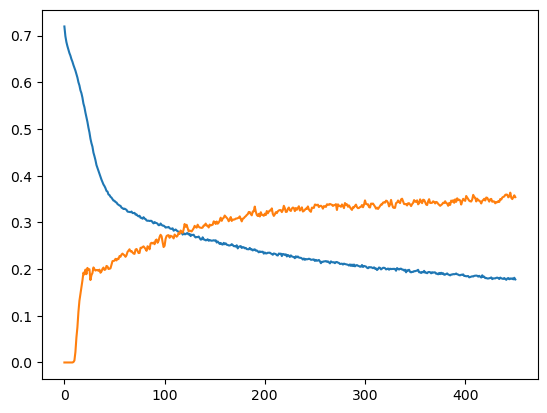

 38%|███▊      | 453/1200 [01:11<01:31,  8.19it/s]

Epoch 451/1200 - loss: 0.1777649944027265, f1: 0.35407590674791034


 38%|███▊      | 459/1200 [01:11<01:03, 11.70it/s]

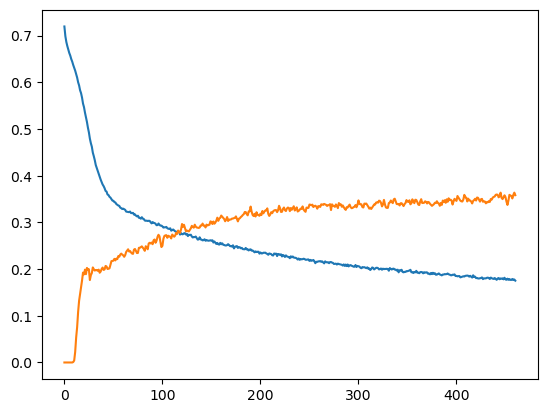

 38%|███▊      | 461/1200 [01:12<02:00,  6.15it/s]

Epoch 461/1200 - loss: 0.17519210775693259, f1: 0.3582279710038847


 39%|███▉      | 469/1200 [01:13<01:37,  7.51it/s]

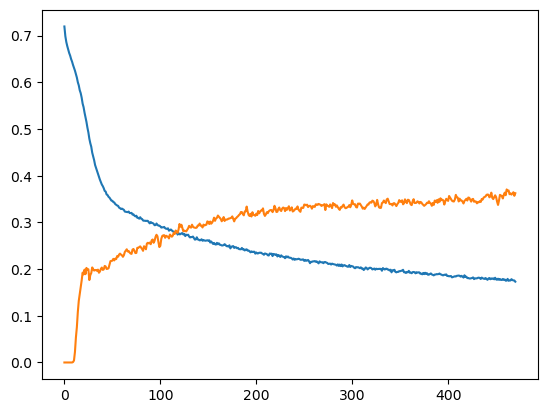

 39%|███▉      | 473/1200 [01:13<01:17,  9.37it/s]

Epoch 471/1200 - loss: 0.17306321362654367, f1: 0.36246878532835225


 40%|███▉      | 479/1200 [01:14<00:58, 12.29it/s]

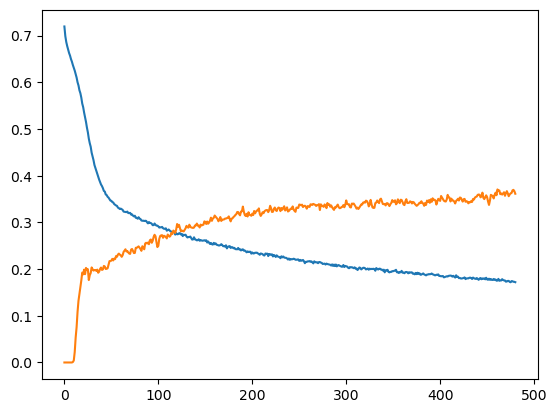

 40%|████      | 483/1200 [01:14<01:00, 11.77it/s]

Epoch 481/1200 - loss: 0.17195905248324075, f1: 0.36135328238869724


 41%|████      | 489/1200 [01:15<01:29,  7.98it/s]

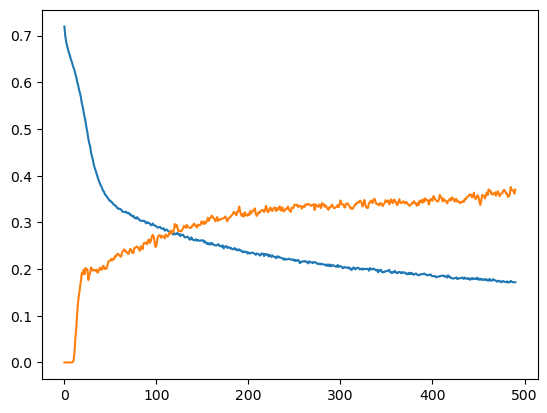

 41%|████      | 493/1200 [01:15<01:15,  9.43it/s]

Epoch 491/1200 - loss: 0.17194748918215433, f1: 0.3700085435607218


 42%|████▏     | 499/1200 [01:16<01:02, 11.30it/s]

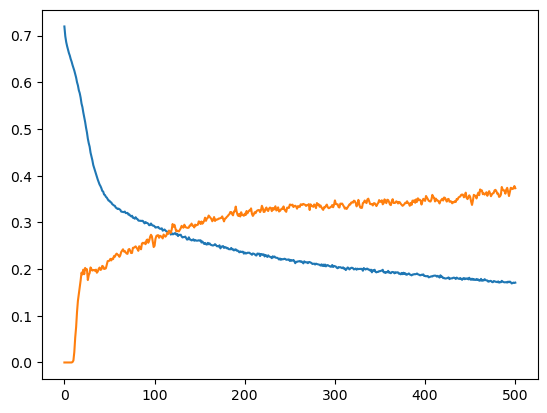

 42%|████▏     | 502/1200 [01:17<01:58,  5.88it/s]

Epoch 501/1200 - loss: 0.1709585984547933, f1: 0.37327273129265837


 42%|████▎     | 510/1200 [01:17<00:59, 11.62it/s]

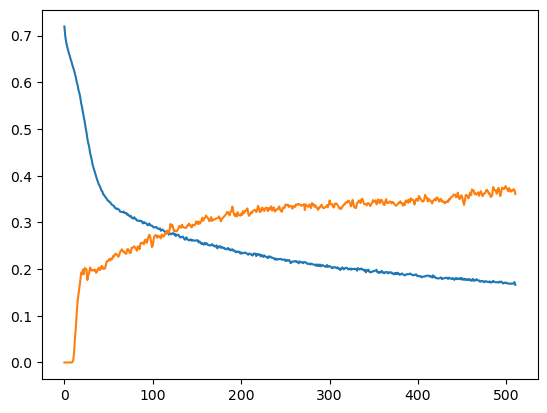

 43%|████▎     | 512/1200 [01:18<01:01, 11.10it/s]

Epoch 511/1200 - loss: 0.1662739838163058, f1: 0.36079072528369427


 43%|████▎     | 520/1200 [01:19<01:37,  7.01it/s]

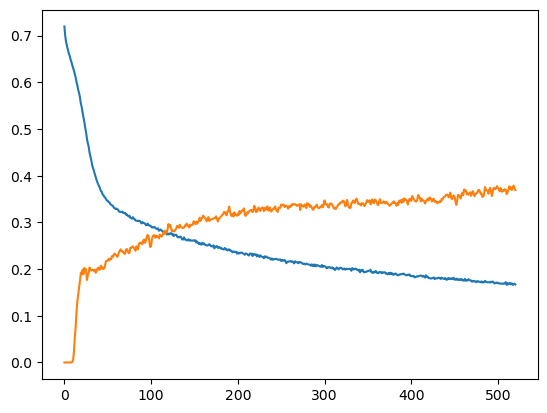

 44%|████▎     | 522/1200 [01:19<01:29,  7.58it/s]

Epoch 521/1200 - loss: 0.16723135858774185, f1: 0.3691508106057265


 44%|████▍     | 530/1200 [01:19<00:56, 11.76it/s]

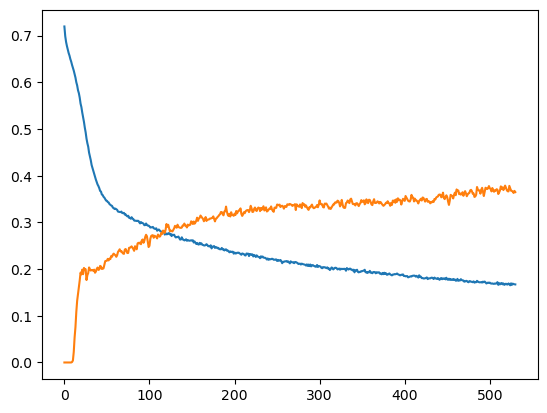

 44%|████▍     | 534/1200 [01:20<00:53, 12.53it/s]

Epoch 531/1200 - loss: 0.1671643058458964, f1: 0.3649385633615936


 45%|████▌     | 540/1200 [01:21<01:22,  8.03it/s]

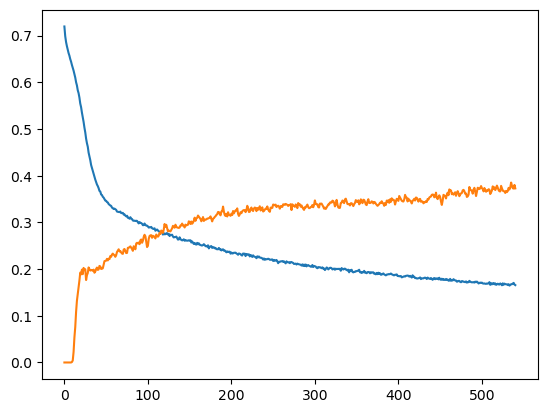

 45%|████▌     | 544/1200 [01:21<01:05,  9.95it/s]

Epoch 541/1200 - loss: 0.16566543529431024, f1: 0.37283741836805545


 46%|████▌     | 550/1200 [01:21<00:52, 12.32it/s]

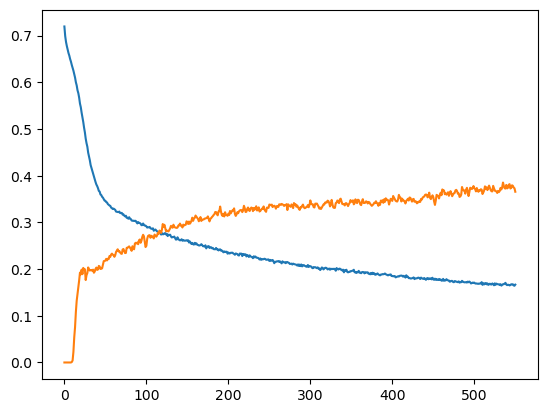

 46%|████▌     | 552/1200 [01:22<00:58, 11.07it/s]

Epoch 551/1200 - loss: 0.16669184217850366, f1: 0.36565970311360096


 47%|████▋     | 560/1200 [01:22<00:48, 13.21it/s]

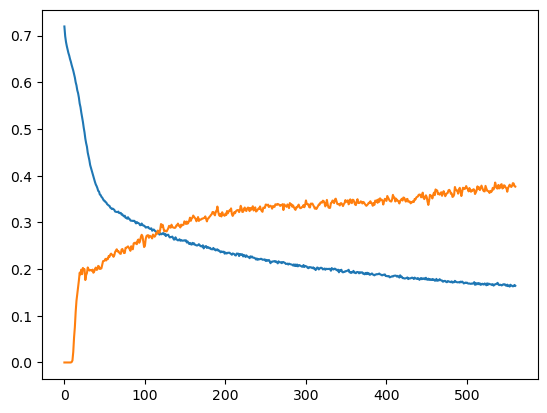

 47%|████▋     | 562/1200 [01:22<00:51, 12.37it/s]

Epoch 561/1200 - loss: 0.164252499739329, f1: 0.3766711854070268


 48%|████▊     | 570/1200 [01:23<00:44, 14.01it/s]

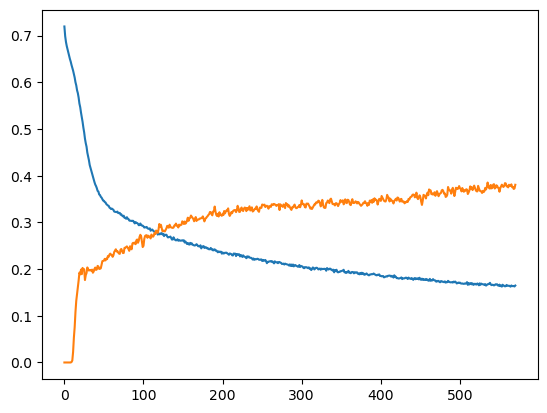

 48%|████▊     | 572/1200 [01:23<01:00, 10.38it/s]

Epoch 571/1200 - loss: 0.16477279365062714, f1: 0.3805534515164938


 48%|████▊     | 580/1200 [01:24<00:45, 13.77it/s]

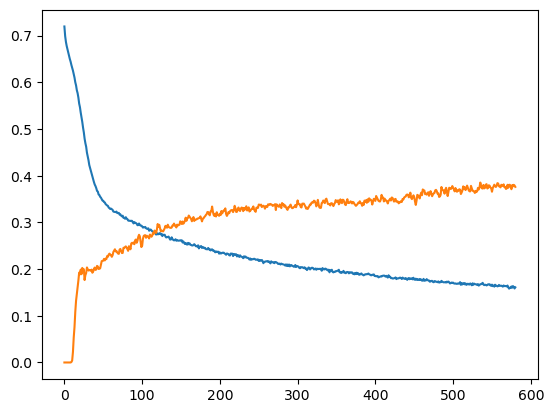

 48%|████▊     | 582/1200 [01:24<00:53, 11.54it/s]

Epoch 581/1200 - loss: 0.1609143763780594, f1: 0.3760563897989915


 49%|████▉     | 590/1200 [01:25<00:43, 13.95it/s]

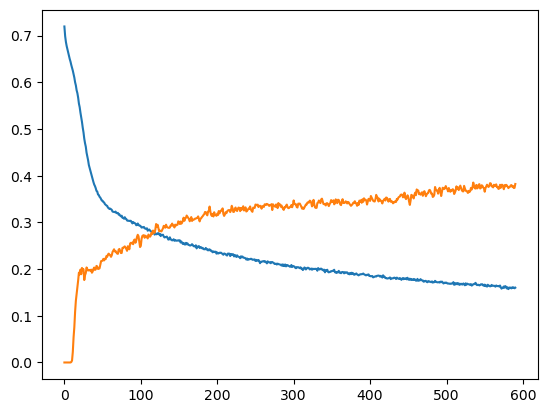

 49%|████▉     | 592/1200 [01:25<00:52, 11.60it/s]

Epoch 591/1200 - loss: 0.16012564798196158, f1: 0.38226842901380187


 50%|█████     | 600/1200 [01:25<00:44, 13.63it/s]

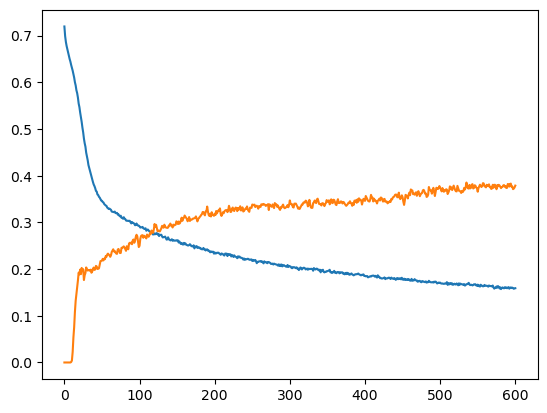

 50%|█████     | 602/1200 [01:26<00:49, 12.15it/s]

Epoch 601/1200 - loss: 0.15903204182783762, f1: 0.37876621236094277


 51%|█████     | 610/1200 [01:27<01:56,  5.07it/s]

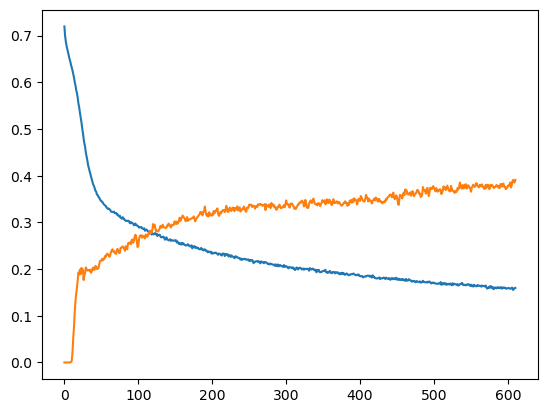

Epoch 611/1200 - loss: 0.15967690447966257, f1: 0.39106191231907467


 52%|█████▏    | 620/1200 [01:29<01:04,  8.99it/s]

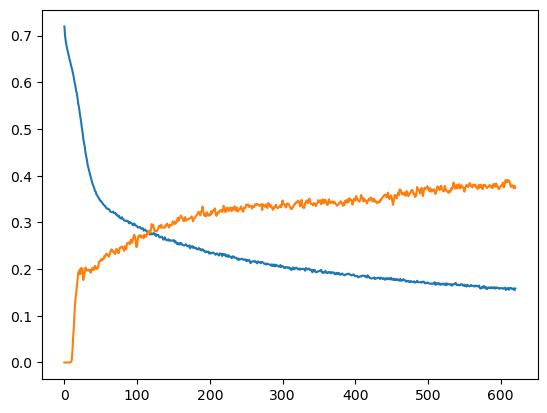

 52%|█████▏    | 624/1200 [01:29<00:56, 10.14it/s]

Epoch 621/1200 - loss: 0.1584711124499639, f1: 0.37394942961286226


 52%|█████▎    | 630/1200 [01:29<00:46, 12.27it/s]

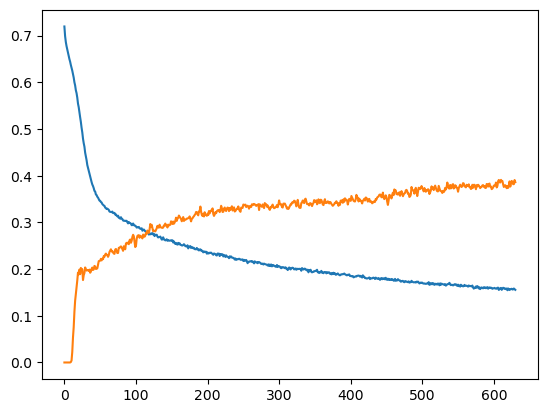

 53%|█████▎    | 632/1200 [01:30<00:49, 11.59it/s]

Epoch 631/1200 - loss: 0.15556218971808752, f1: 0.3861394723317422


 53%|█████▎    | 640/1200 [01:31<01:23,  6.73it/s]

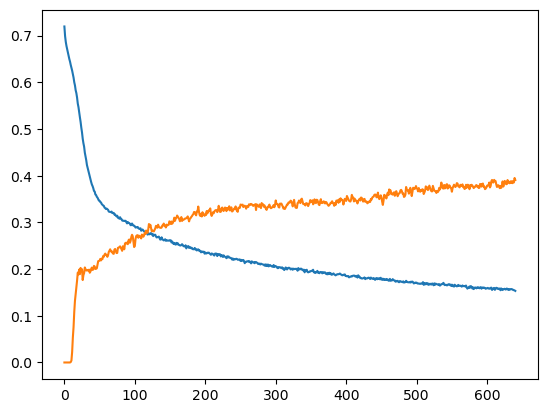

 54%|█████▎    | 643/1200 [01:31<01:15,  7.35it/s]

Epoch 641/1200 - loss: 0.15325927237669626, f1: 0.39076915371353405


 54%|█████▍    | 649/1200 [01:32<01:08,  7.99it/s]

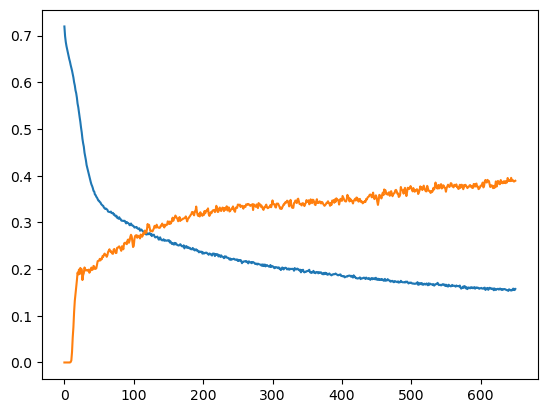

 54%|█████▍    | 653/1200 [01:32<00:58,  9.42it/s]

Epoch 651/1200 - loss: 0.1574032853047053, f1: 0.38917325924023116


 55%|█████▍    | 659/1200 [01:33<00:42, 12.61it/s]

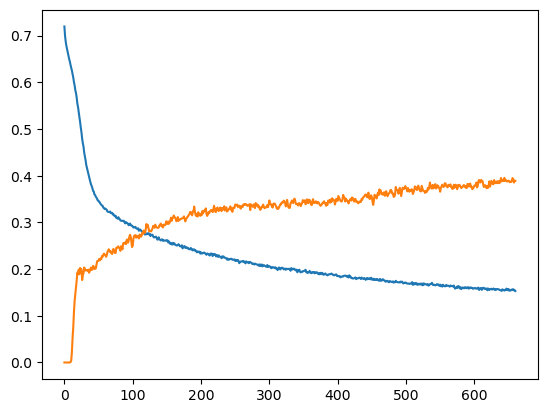

 55%|█████▌    | 663/1200 [01:33<00:47, 11.24it/s]

Epoch 661/1200 - loss: 0.15307279179493585, f1: 0.38901854655094126


 56%|█████▌    | 669/1200 [01:34<00:41, 12.76it/s]

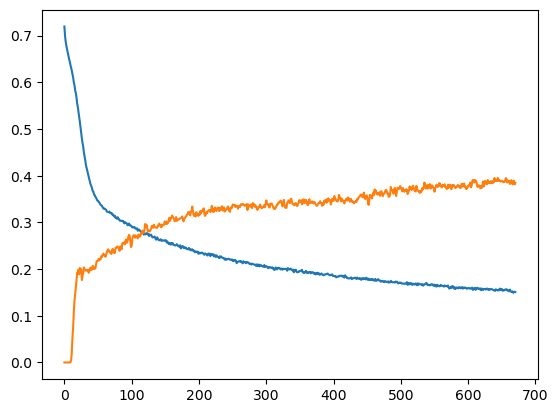

 56%|█████▌    | 673/1200 [01:34<00:42, 12.27it/s]

Epoch 671/1200 - loss: 0.15097266932328543, f1: 0.38463101813198664


 57%|█████▋    | 679/1200 [01:35<00:44, 11.69it/s]

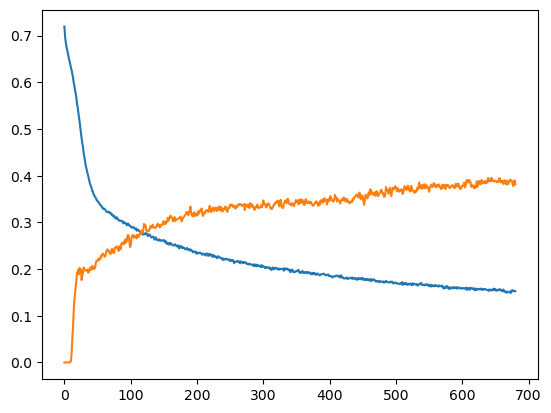

 57%|█████▋    | 683/1200 [01:35<00:42, 12.10it/s]

Epoch 681/1200 - loss: 0.15279117226600647, f1: 0.3816591706820318


 57%|█████▋    | 689/1200 [01:35<00:37, 13.62it/s]

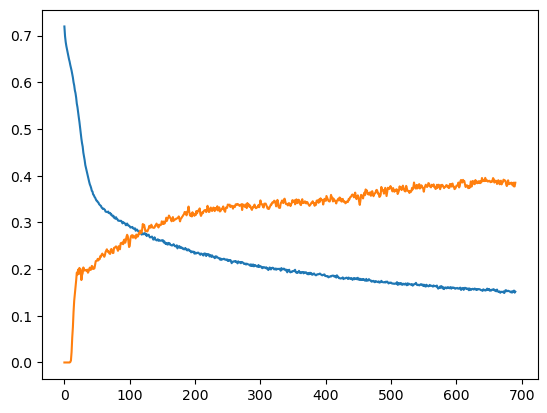

 58%|█████▊    | 693/1200 [01:36<00:39, 12.80it/s]

Epoch 691/1200 - loss: 0.1516773005326589, f1: 0.38500270077657034


 58%|█████▊    | 699/1200 [01:36<00:38, 12.99it/s]

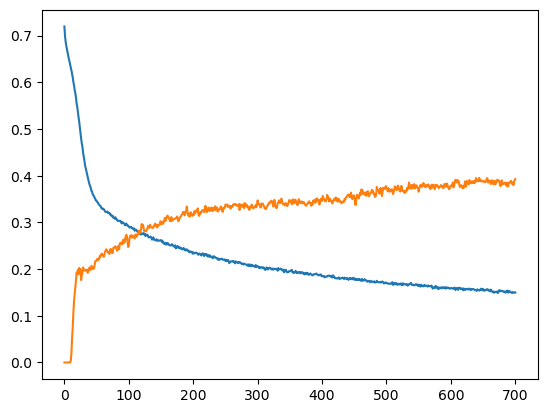

 59%|█████▊    | 703/1200 [01:36<00:38, 13.01it/s]

Epoch 701/1200 - loss: 0.14979039132595062, f1: 0.3927047345359256


 59%|█████▉    | 709/1200 [01:37<00:37, 13.22it/s]

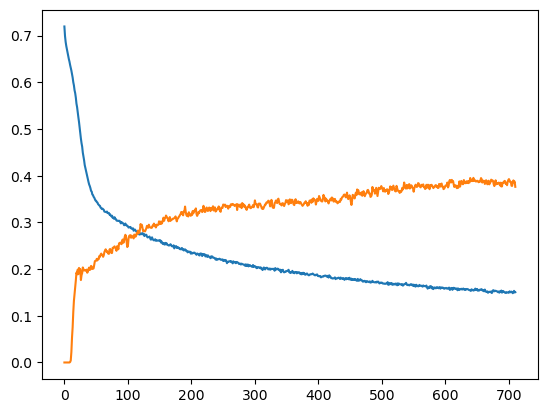

 59%|█████▉    | 713/1200 [01:37<00:45, 10.77it/s]

Epoch 711/1200 - loss: 0.15049727509419122, f1: 0.37616399414001994


 60%|█████▉    | 719/1200 [01:38<00:36, 13.23it/s]

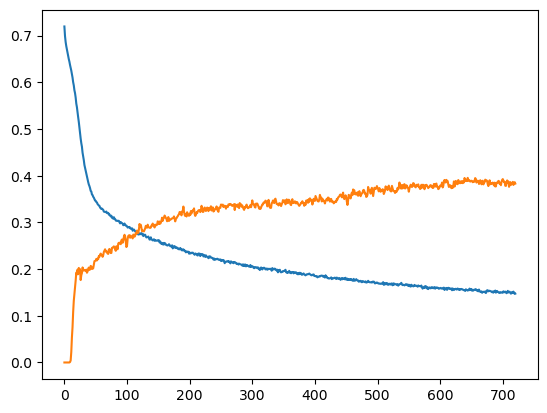

 60%|██████    | 723/1200 [01:38<00:39, 12.23it/s]

Epoch 721/1200 - loss: 0.14745067059993744, f1: 0.38309461641261394


 61%|██████    | 729/1200 [01:39<00:35, 13.13it/s]

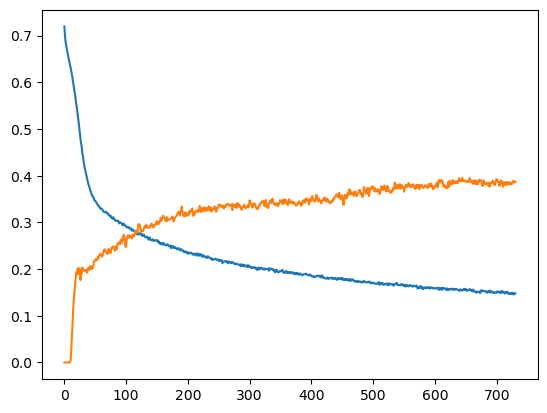

 61%|██████    | 733/1200 [01:39<00:38, 11.98it/s]

Epoch 731/1200 - loss: 0.1480806345740954, f1: 0.38681789941091965


 62%|██████▏   | 739/1200 [01:39<00:35, 12.84it/s]

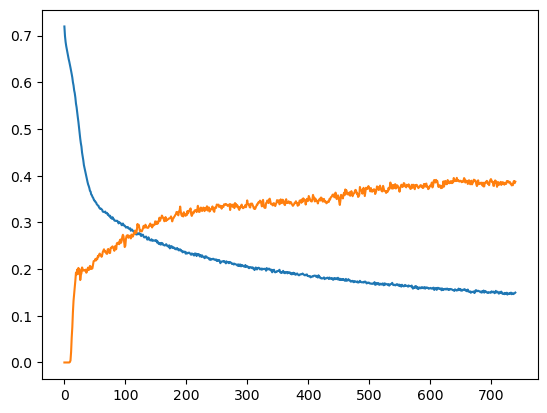

 62%|██████▏   | 743/1200 [01:40<00:38, 11.90it/s]

Epoch 741/1200 - loss: 0.14965951691071191, f1: 0.38723898711923993


 62%|██████▏   | 749/1200 [01:40<00:36, 12.23it/s]

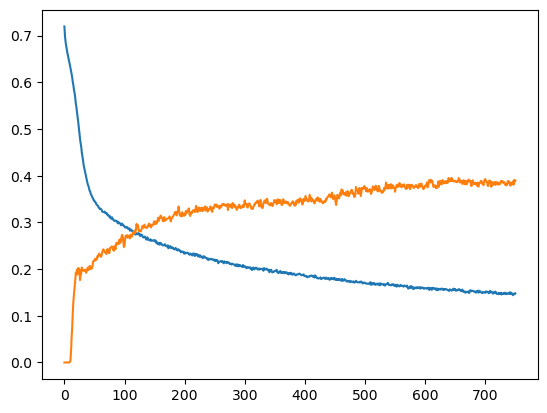

 63%|██████▎   | 753/1200 [01:41<00:37, 12.02it/s]

Epoch 751/1200 - loss: 0.14819328486919403, f1: 0.3894448092768546


 63%|██████▎   | 759/1200 [01:41<00:30, 14.45it/s]

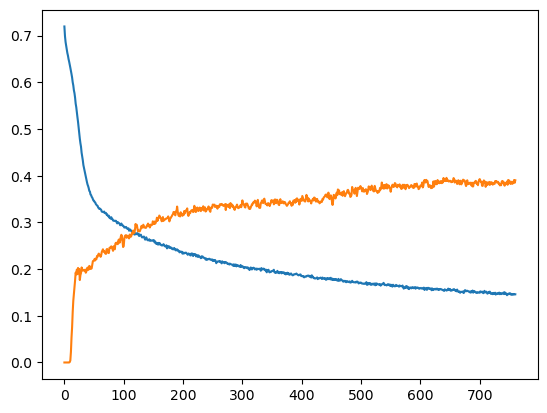

 64%|██████▎   | 763/1200 [01:41<00:32, 13.29it/s]

Epoch 761/1200 - loss: 0.14604424436887106, f1: 0.390091951708201


 64%|██████▍   | 769/1200 [01:42<00:29, 14.56it/s]

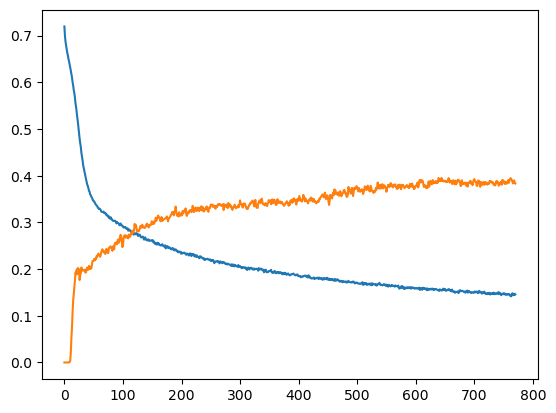

 64%|██████▍   | 773/1200 [01:42<00:34, 12.30it/s]

Epoch 771/1200 - loss: 0.14575930188099542, f1: 0.3832919964074082


 65%|██████▍   | 779/1200 [01:42<00:28, 14.56it/s]

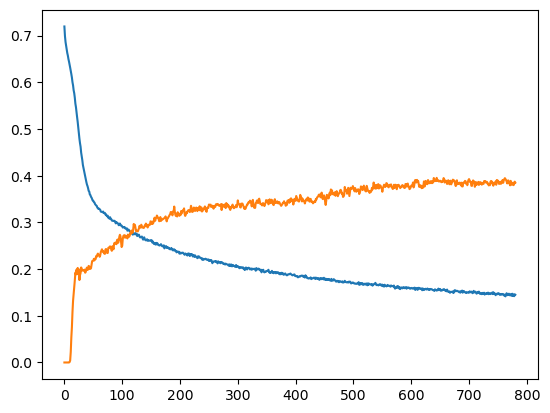

 65%|██████▌   | 783/1200 [01:43<00:36, 11.38it/s]

Epoch 781/1200 - loss: 0.14502778400977454, f1: 0.3851376102277039


 66%|██████▌   | 789/1200 [01:43<00:30, 13.47it/s]

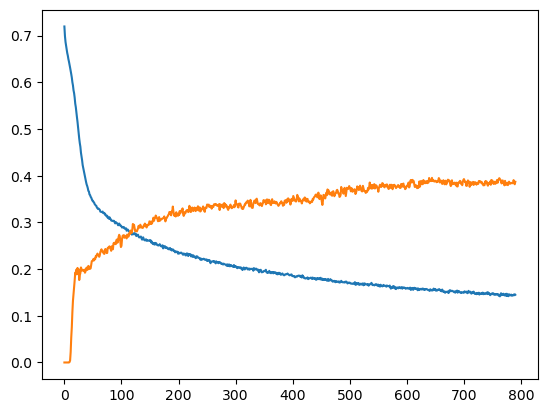

 66%|██████▌   | 791/1200 [01:43<00:32, 12.45it/s]

Epoch 791/1200 - loss: 0.14495685944954553, f1: 0.3869782134190859


 67%|██████▋   | 799/1200 [01:45<00:37, 10.72it/s]

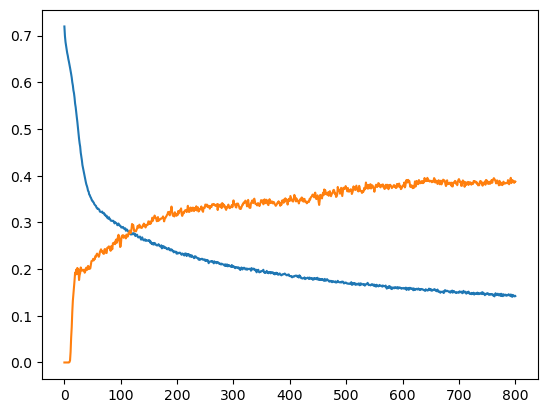

 67%|██████▋   | 803/1200 [01:45<00:34, 11.57it/s]

Epoch 801/1200 - loss: 0.14222954461971918, f1: 0.38747014615844055


 67%|██████▋   | 809/1200 [01:46<00:43,  9.06it/s]

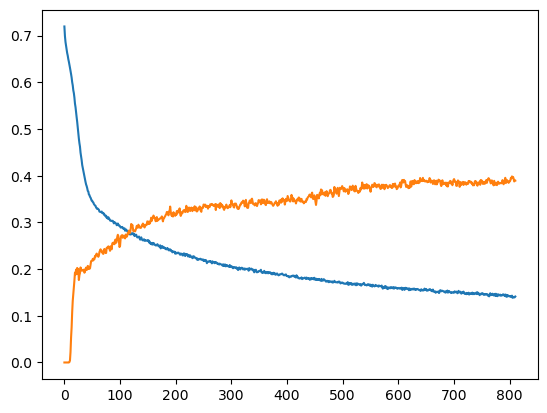

 68%|██████▊   | 813/1200 [01:46<00:36, 10.55it/s]

Epoch 811/1200 - loss: 0.14127501100301743, f1: 0.3895443845101778


 68%|██████▊   | 819/1200 [01:47<00:32, 11.80it/s]

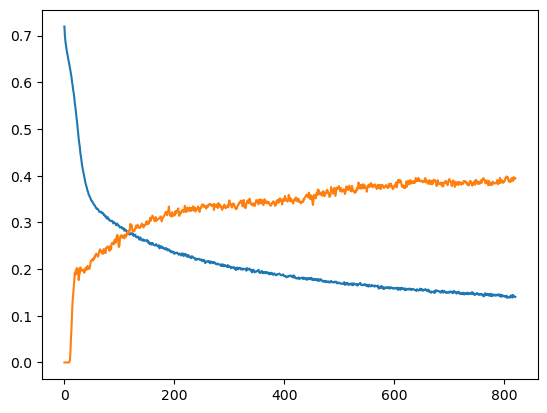

 69%|██████▊   | 823/1200 [01:47<00:33, 11.24it/s]

Epoch 821/1200 - loss: 0.14035691817601523, f1: 0.3942598172554074


 69%|██████▉   | 829/1200 [01:48<01:20,  4.62it/s]

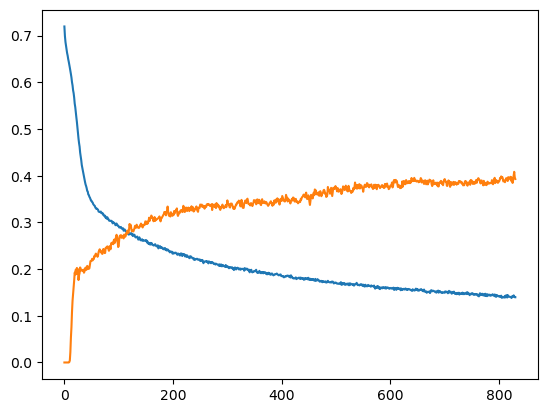

 69%|██████▉   | 833/1200 [01:49<00:56,  6.54it/s]

Epoch 831/1200 - loss: 0.13970796267191568, f1: 0.3928894303207418


 70%|██████▉   | 839/1200 [01:49<00:37,  9.61it/s]

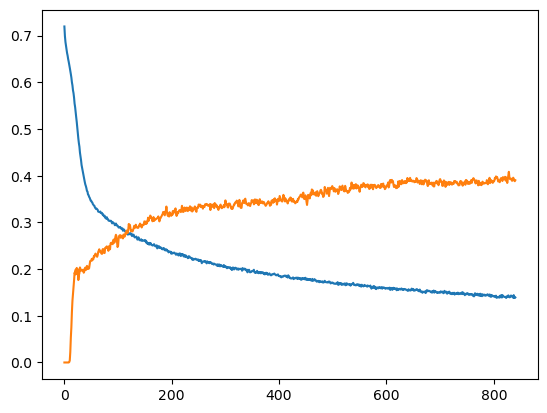

 70%|███████   | 843/1200 [01:49<00:33, 10.69it/s]

Epoch 841/1200 - loss: 0.13932985812425613, f1: 0.3902999665930681


 71%|███████   | 849/1200 [01:50<00:26, 13.23it/s]

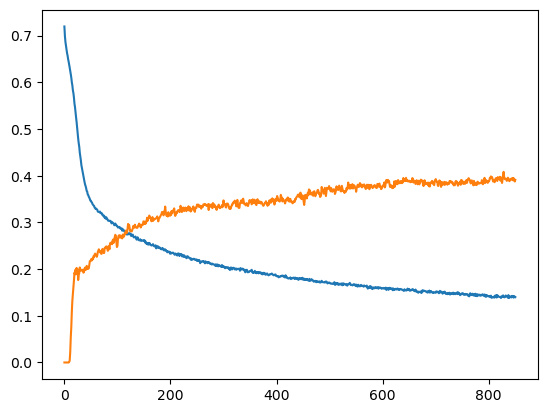

 71%|███████   | 851/1200 [01:50<00:28, 12.09it/s]

Epoch 851/1200 - loss: 0.13995777318874994, f1: 0.39118676968030536


 72%|███████▏  | 859/1200 [01:51<00:28, 11.92it/s]

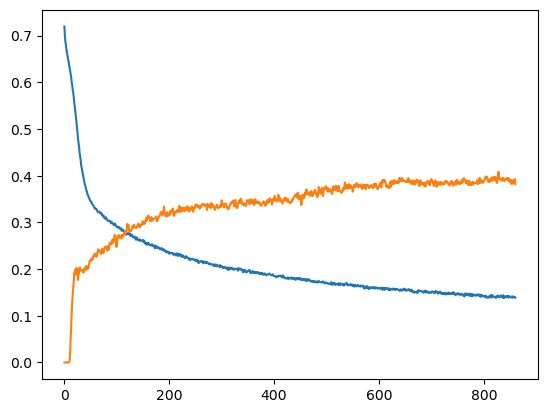

 72%|███████▏  | 863/1200 [01:51<00:27, 12.35it/s]

Epoch 861/1200 - loss: 0.1388097951809565, f1: 0.38182553889534454


 72%|███████▏  | 869/1200 [01:52<00:25, 12.83it/s]

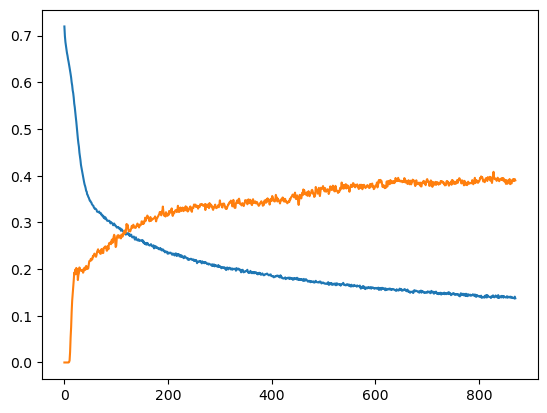

 73%|███████▎  | 873/1200 [01:52<00:28, 11.43it/s]

Epoch 871/1200 - loss: 0.13740914314985275, f1: 0.38992895019769486


 73%|███████▎  | 879/1200 [01:52<00:24, 12.94it/s]

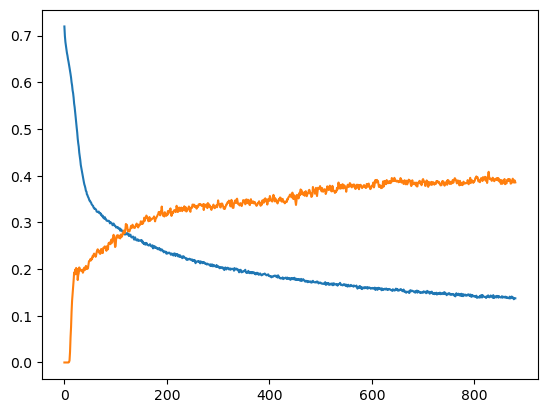

 74%|███████▎  | 883/1200 [01:53<00:26, 12.07it/s]

Epoch 881/1200 - loss: 0.13743546605110168, f1: 0.3856319312526924


 74%|███████▍  | 889/1200 [01:53<00:25, 12.04it/s]

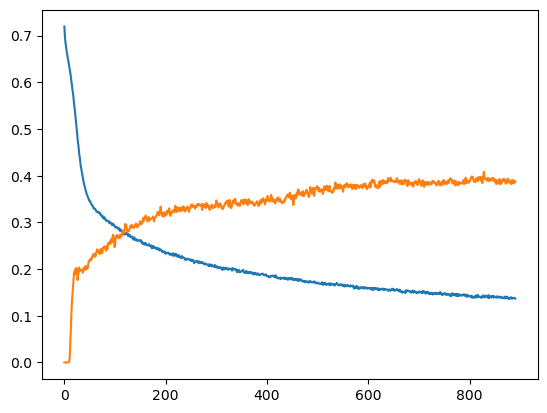

 74%|███████▍  | 893/1200 [01:54<00:25, 11.98it/s]

Epoch 891/1200 - loss: 0.1370104377468427, f1: 0.38691433817098797


 75%|███████▍  | 899/1200 [01:54<00:21, 13.73it/s]

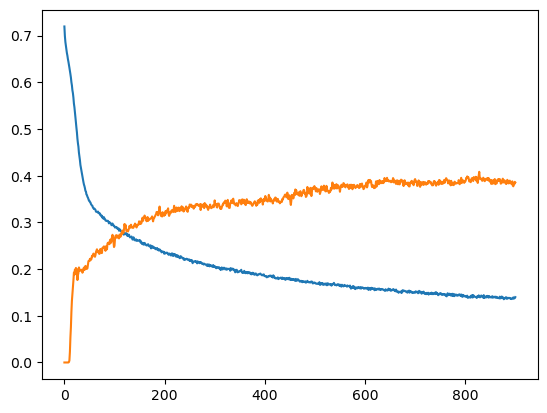

 75%|███████▌  | 903/1200 [01:54<00:24, 12.20it/s]

Epoch 901/1200 - loss: 0.13994635393222174, f1: 0.38561929965757813


 76%|███████▌  | 909/1200 [01:55<00:21, 13.34it/s]

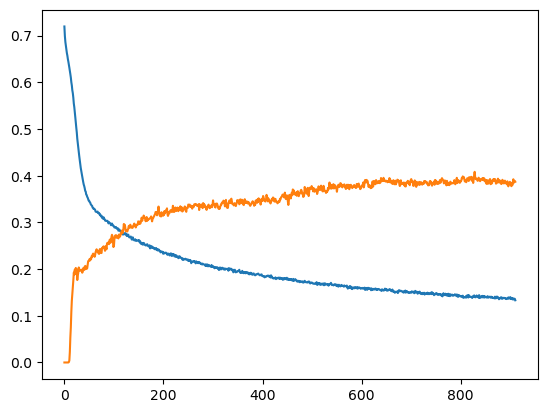

 76%|███████▌  | 913/1200 [01:55<00:22, 12.83it/s]

Epoch 911/1200 - loss: 0.13320275892814, f1: 0.3870744193583764


 77%|███████▋  | 919/1200 [01:56<00:23, 11.95it/s]

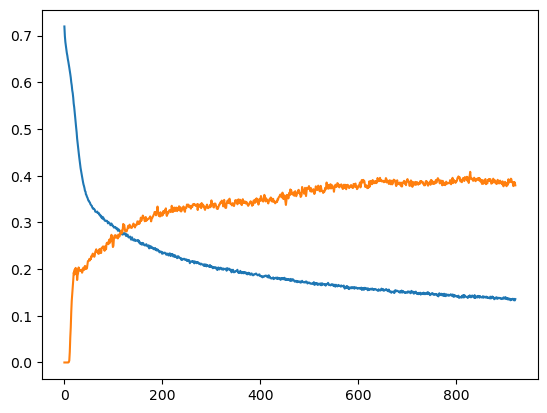

 77%|███████▋  | 921/1200 [01:56<00:25, 11.16it/s]

Epoch 921/1200 - loss: 0.13570613910754523, f1: 0.37936355040722325


 77%|███████▋  | 929/1200 [01:57<00:21, 12.63it/s]

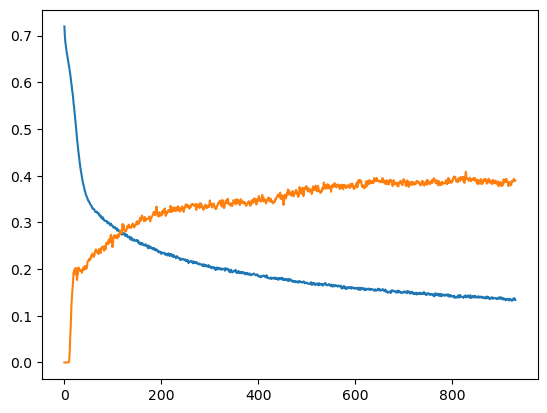

 78%|███████▊  | 933/1200 [01:57<00:22, 11.75it/s]

Epoch 931/1200 - loss: 0.13377045094966888, f1: 0.3897178457799273


 78%|███████▊  | 939/1200 [01:57<00:18, 14.01it/s]

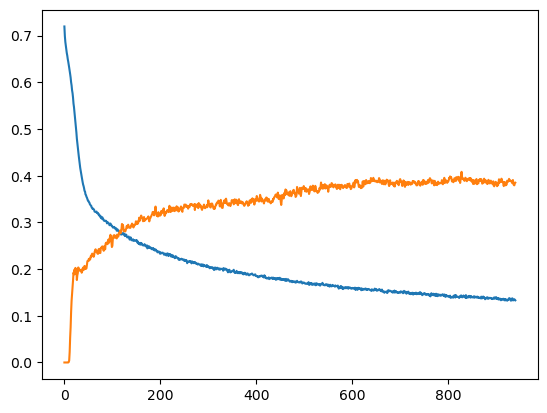

 79%|███████▊  | 943/1200 [01:58<00:18, 13.54it/s]

Epoch 941/1200 - loss: 0.1331049365301927, f1: 0.3850093509401925


 79%|███████▉  | 949/1200 [01:58<00:18, 13.67it/s]

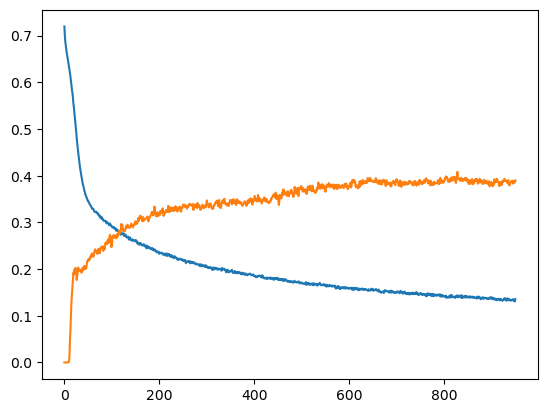

 79%|███████▉  | 953/1200 [01:58<00:18, 13.01it/s]

Epoch 951/1200 - loss: 0.13559688876072565, f1: 0.39001128748388836


 80%|███████▉  | 959/1200 [01:59<00:20, 11.76it/s]

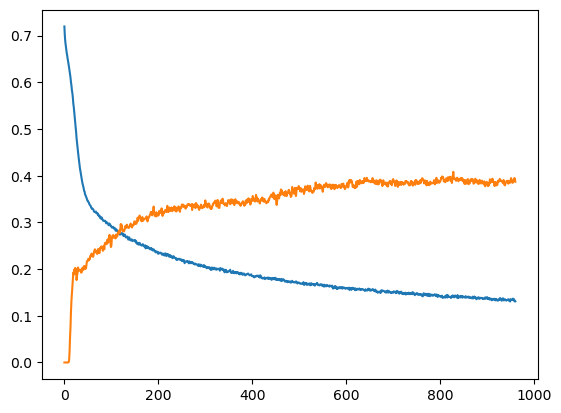

 80%|████████  | 963/1200 [01:59<00:21, 11.23it/s]

Epoch 961/1200 - loss: 0.1310228928923607, f1: 0.3871436864099033


 81%|████████  | 969/1200 [02:00<00:18, 12.69it/s]

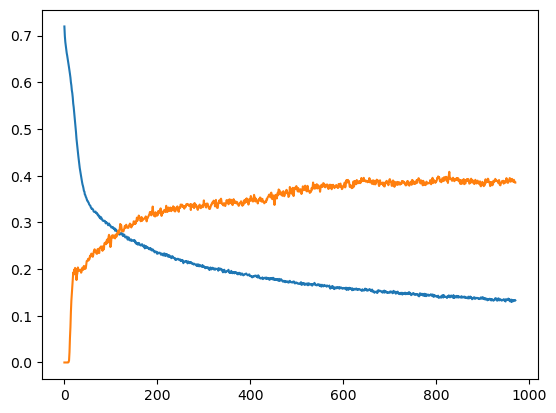

 81%|████████  | 973/1200 [02:00<00:18, 12.53it/s]

Epoch 971/1200 - loss: 0.13303337742884955, f1: 0.3852784377473245


 82%|████████▏ | 979/1200 [02:01<00:16, 13.66it/s]

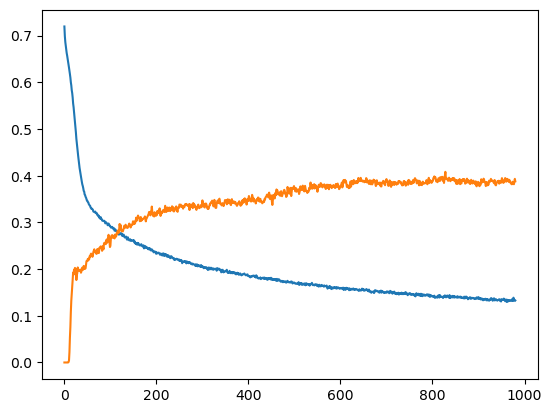

 82%|████████▏ | 983/1200 [02:01<00:18, 11.56it/s]

Epoch 981/1200 - loss: 0.13285542279481888, f1: 0.38803477984613743


 82%|████████▏ | 989/1200 [02:01<00:14, 14.17it/s]

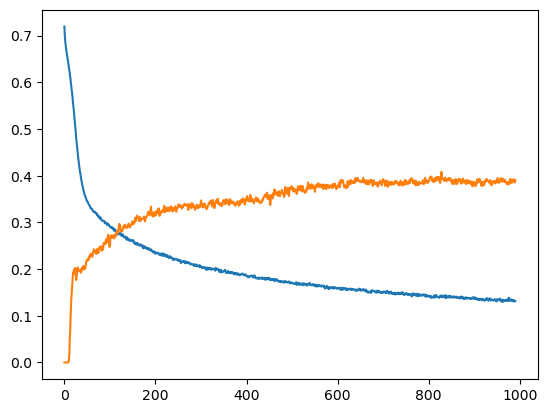

 83%|████████▎ | 991/1200 [02:02<00:16, 12.90it/s]

Epoch 991/1200 - loss: 0.13133337597052255, f1: 0.3908068964706729


 83%|████████▎ | 999/1200 [02:02<00:15, 12.92it/s]

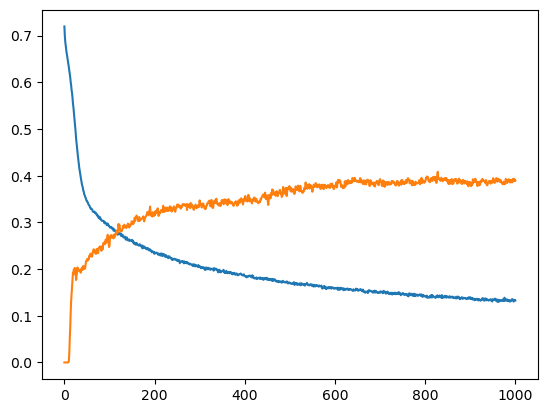

 84%|████████▎ | 1003/1200 [02:03<00:16, 12.08it/s]

Epoch 1001/1200 - loss: 0.13260483741760254, f1: 0.38962225678019874


 84%|████████▍ | 1009/1200 [02:03<00:14, 13.07it/s]

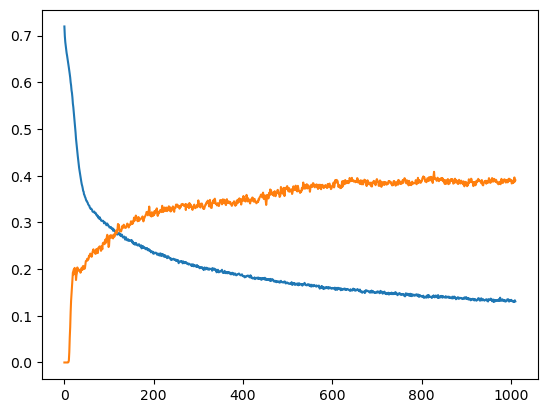

 84%|████████▍ | 1013/1200 [02:03<00:15, 12.29it/s]

Epoch 1011/1200 - loss: 0.1307614085574945, f1: 0.39007890187295624


 85%|████████▍ | 1019/1200 [02:04<00:14, 12.84it/s]

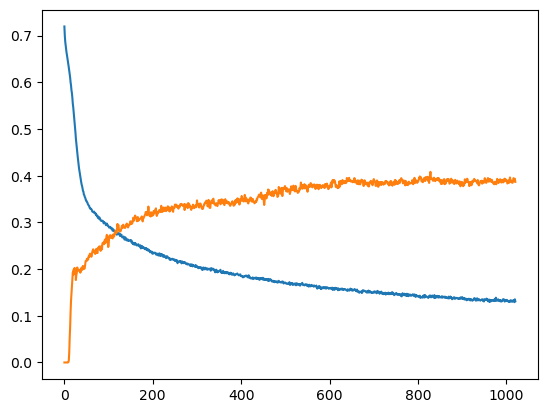

 85%|████████▌ | 1023/1200 [02:04<00:14, 12.31it/s]

Epoch 1021/1200 - loss: 0.13114808996518454, f1: 0.38681201891014605


 86%|████████▌ | 1029/1200 [02:05<00:16, 10.28it/s]

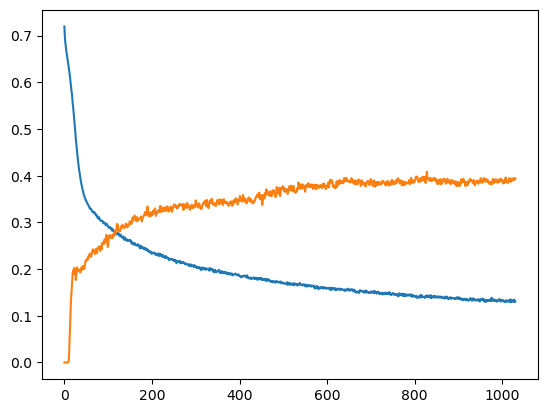

 86%|████████▌ | 1033/1200 [02:05<00:14, 11.62it/s]

Epoch 1031/1200 - loss: 0.13112094750006995, f1: 0.3941867506854319


 87%|████████▋ | 1039/1200 [02:06<00:13, 12.29it/s]

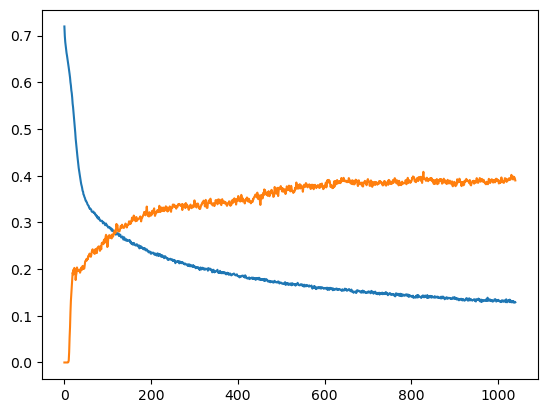

 87%|████████▋ | 1043/1200 [02:06<00:14, 10.72it/s]

Epoch 1041/1200 - loss: 0.1289316639304161, f1: 0.38987615802220943


 87%|████████▋ | 1049/1200 [02:06<00:11, 13.07it/s]

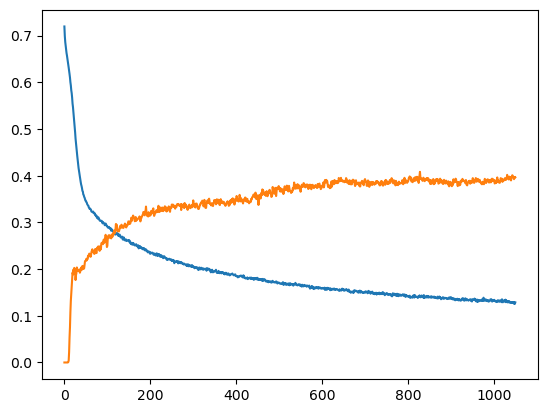

 88%|████████▊ | 1053/1200 [02:07<00:12, 12.12it/s]

Epoch 1051/1200 - loss: 0.128689955919981, f1: 0.3964838144887227


 88%|████████▊ | 1059/1200 [02:07<00:10, 13.60it/s]

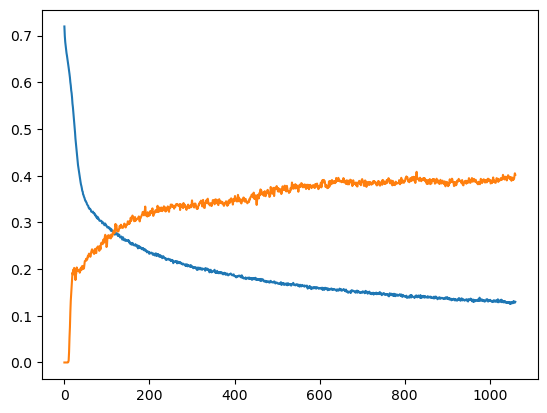

 88%|████████▊ | 1061/1200 [02:07<00:10, 12.83it/s]

Epoch 1061/1200 - loss: 0.12984316299359003, f1: 0.4018787577244364


 89%|████████▉ | 1069/1200 [02:08<00:09, 13.41it/s]

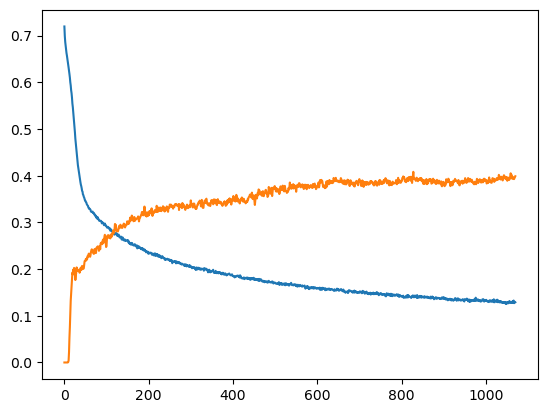

 89%|████████▉ | 1073/1200 [02:08<00:10, 12.04it/s]

Epoch 1071/1200 - loss: 0.12899005661408106, f1: 0.3988714653414389


 90%|████████▉ | 1079/1200 [02:09<00:08, 13.97it/s]

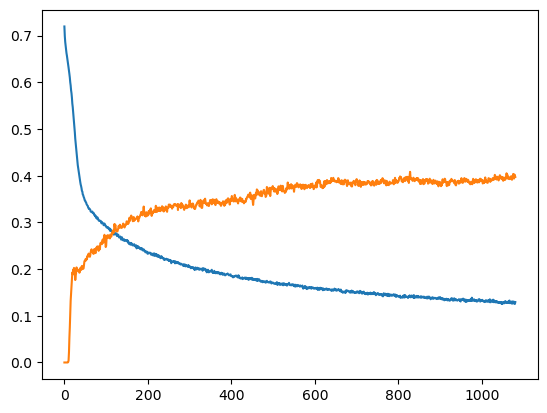

 90%|█████████ | 1083/1200 [02:09<00:09, 12.83it/s]

Epoch 1081/1200 - loss: 0.1292951504389445, f1: 0.39736202076415217


 91%|█████████ | 1089/1200 [02:10<00:12,  9.22it/s]

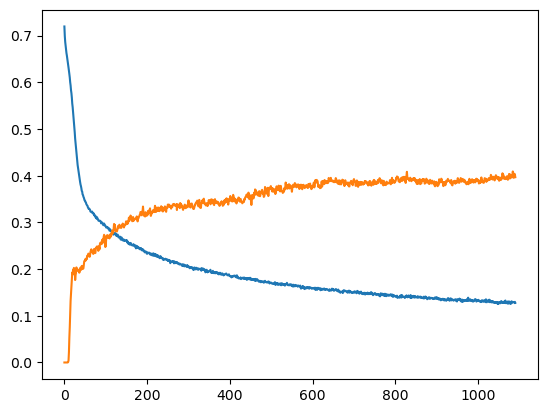

 91%|█████████ | 1091/1200 [02:10<00:11,  9.62it/s]

Epoch 1091/1200 - loss: 0.12772716954350471, f1: 0.39682863243998223


 92%|█████████▏| 1099/1200 [02:11<00:10,  9.97it/s]

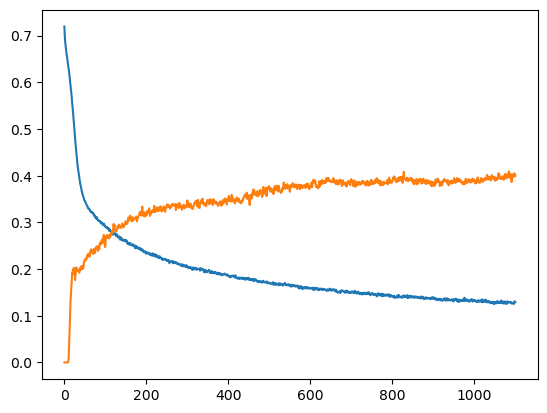

 92%|█████████▏| 1103/1200 [02:11<00:09, 10.53it/s]

Epoch 1101/1200 - loss: 0.1292261096338431, f1: 0.3991678629896903


 92%|█████████▏| 1109/1200 [02:12<00:07, 12.82it/s]

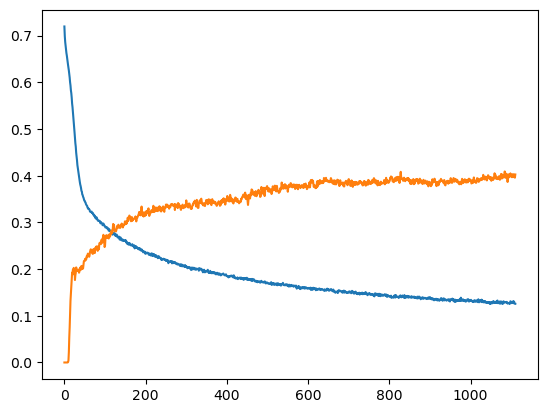

 93%|█████████▎| 1113/1200 [02:12<00:07, 11.48it/s]

Epoch 1111/1200 - loss: 0.12568464502692223, f1: 0.40258807949564035


 93%|█████████▎| 1119/1200 [02:13<00:06, 12.64it/s]

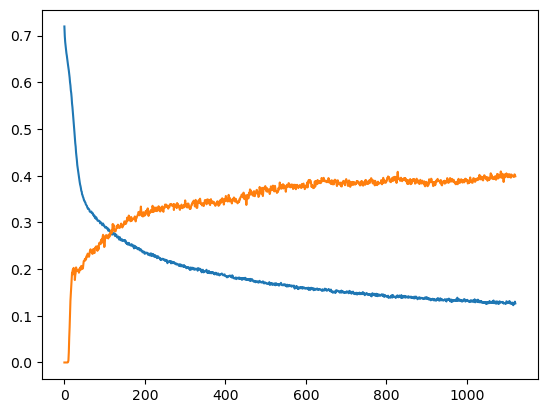

 94%|█████████▎| 1123/1200 [02:13<00:06, 11.77it/s]

Epoch 1121/1200 - loss: 0.12656100342671076, f1: 0.39872536934499897


 94%|█████████▍| 1129/1200 [02:14<00:09,  7.79it/s]

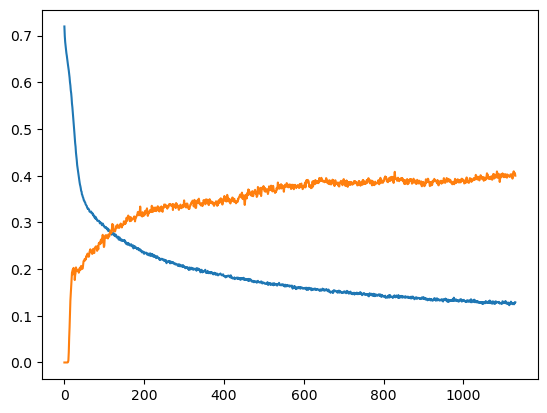

 94%|█████████▍| 1131/1200 [02:14<00:08,  7.69it/s]

Epoch 1131/1200 - loss: 0.1288849674165249, f1: 0.3999941783827572


 95%|█████████▍| 1139/1200 [02:15<00:06, 10.10it/s]

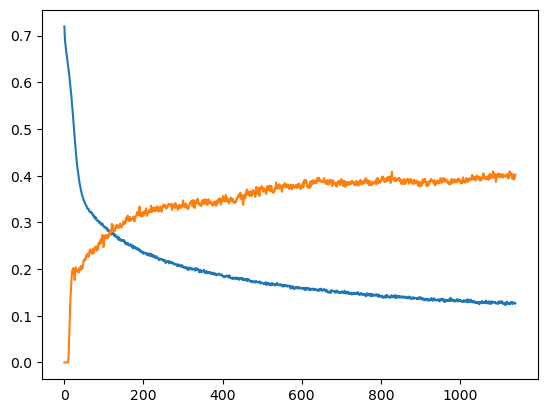

 95%|█████████▌| 1143/1200 [02:15<00:05, 10.57it/s]

Epoch 1141/1200 - loss: 0.1266049121816953, f1: 0.4024865974101456


 96%|█████████▌| 1149/1200 [02:16<00:04, 12.17it/s]

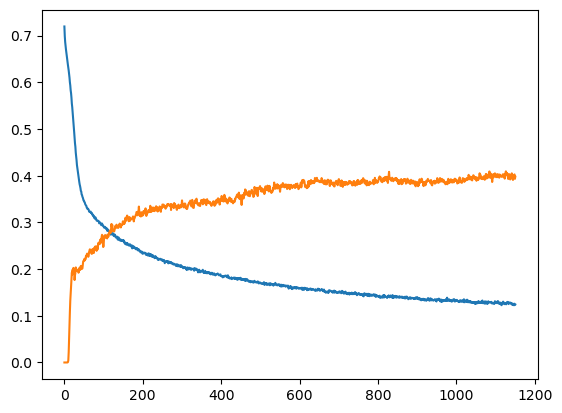

 96%|█████████▌| 1153/1200 [02:16<00:04, 11.23it/s]

Epoch 1151/1200 - loss: 0.12416665256023407, f1: 0.39783100367446245


 97%|█████████▋| 1159/1200 [02:17<00:03, 12.82it/s]

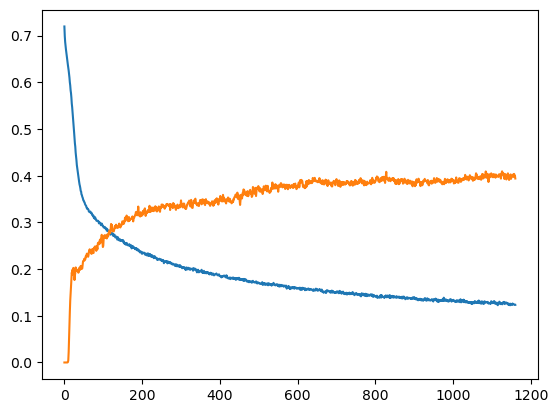

 97%|█████████▋| 1163/1200 [02:17<00:03, 11.22it/s]

Epoch 1161/1200 - loss: 0.12337534377972285, f1: 0.39401404817570373


 97%|█████████▋| 1169/1200 [02:17<00:02, 10.74it/s]

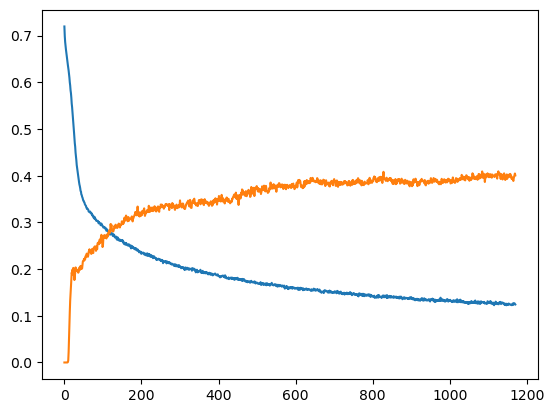

 98%|█████████▊| 1173/1200 [02:18<00:02, 10.86it/s]

Epoch 1171/1200 - loss: 0.12416211515665054, f1: 0.400737702183071


 98%|█████████▊| 1179/1200 [02:18<00:01, 13.38it/s]

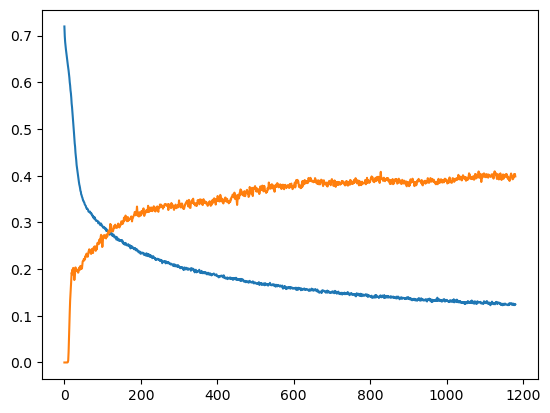

 99%|█████████▊| 1183/1200 [02:19<00:01, 11.98it/s]

Epoch 1181/1200 - loss: 0.12438647324840228, f1: 0.3985083657176134


 99%|█████████▉| 1189/1200 [02:19<00:00, 13.92it/s]

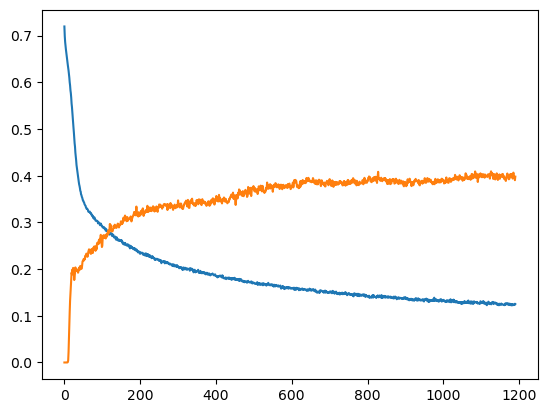

 99%|█████████▉| 1193/1200 [02:19<00:00, 12.55it/s]

Epoch 1191/1200 - loss: 0.12498709683616956, f1: 0.3979482757397096


100%|██████████| 1200/1200 [02:20<00:00,  8.55it/s]


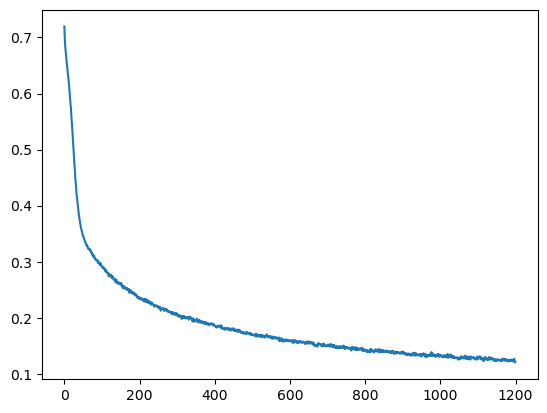

In [10]:
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 1200
losses = []
metrics = []

best_metric = 0

for epoch in tqdm(range(epochs)):

    total_loss = 0
    total_metric = 0
    
    model.train()
    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    model.eval()
    for i, (inputs, labels) in enumerate(val_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        outputs = torch.where(outputs > 0.75, 1, 0)
        outputs = outputs.cpu().detach().numpy()
        labels = labels.cpu().detach().numpy()

        total_metric += f1_score(labels, outputs, average="weighted")

    losses.append(total_loss / len(data_loader))
    metrics.append(total_metric / len(val_loader))
    
    if epoch % 10 == 0:
        plt.plot(losses)
        plt.plot(metrics)
        plt.show()
        print(f"Epoch {epoch + 1}/{epochs} - loss: {losses[-1]}, f1: {metrics[-1]}")

    if metrics[-1] > best_metric:
        best_metric = metrics[-1]
        torch.save(model.state_dict(), "models/hv_classifier.pt")
        
losses = np.array(losses)
np.save("models/hv_classifier_losses.npy", losses)
plt.plot(losses)

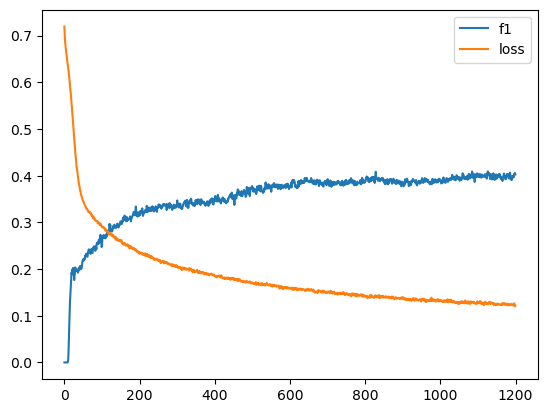

In [11]:
plt.plot(metrics, label="f1")
plt.plot(losses, label="loss")
plt.legend()
plt.show()

In [12]:

outputs = model.predict(df_inputs)
outputs = torch.where(outputs > 0.75, 1, 0)

print(classification_report(df_labels, outputs, target_names=df.columns[:-1]))

                            precision    recall  f1-score   support

                    Merged       1.00      0.98      0.99       988
   Self-direction: thought       1.00      0.99      0.99      1395
    Self-direction: action       1.00      0.01      0.02       247
               Stimulation       0.00      0.00      0.00       172
                  Hedonism       1.00      0.99      0.99      1512
               Achievement       0.99      0.23      0.38       610
          Power: dominance       1.00      0.96      0.98       625
          Power: resources       0.00      0.00      0.00       382
                      Face       1.00      0.98      0.99      2000
        Security: personal       1.00      0.98      0.99      1728
        Security: societal       0.99      0.90      0.94       568
                 Tradition       1.00      0.98      0.99      1177
         Conformity: rules       1.00      0.06      0.12       207
 Conformity: interpersonal       1.00      0.26

c:\Users\mo\anaconda3\envs\ml_env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mo\anaconda3\envs\ml_env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mo\anaconda3\envs\ml_env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [13]:
validation_inputs, validation_labels = load_data("datasets/validation_merged.csv")

outputs = model.predict(validation_inputs)
outputs = torch.where(outputs > 0.75, 1, 0)

print(classification_report(validation_labels, outputs, target_names=df.columns[:-1]))

# save classification report as CSV
report = classification_report(validation_labels, outputs, target_names=df.columns[:-1], output_dict=True)
report = pd.DataFrame(report).transpose()
report.to_csv("reports/validation_performance.csv")


                            precision    recall  f1-score   support

                    Merged       0.57      0.17      0.26       251
   Self-direction: thought       0.48      0.34      0.39       496
    Self-direction: action       1.00      0.01      0.01       138
               Stimulation       0.00      0.00      0.00       103
                  Hedonism       0.59      0.59      0.59       575
               Achievement       0.62      0.03      0.06       164
          Power: dominance       0.25      0.13      0.17       132
          Power: resources       0.00      0.00      0.00       130
                      Face       0.68      0.60      0.63       759
        Security: personal       0.52      0.43      0.47       488
        Security: societal       0.48      0.35      0.41       172
                 Tradition       0.53      0.34      0.41       455
         Conformity: rules       0.00      0.00      0.00        60
 Conformity: interpersonal       0.25      0.07

c:\Users\mo\anaconda3\envs\ml_env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mo\anaconda3\envs\ml_env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mo\anaconda3\envs\ml_env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mo\anaconda3\envs\m

In [14]:
# save model
torch.save(model.state_dict(), "models/hv_net.pt")